* Topic:        Challenge Set 3
* Subject:      Pandas (Exploring and visualizing our scraped movie data in pandas)
* Date:         TODO
* Name:         Michael Green ( malexgreen@gmail.com )

What data do I need to read in if I'm going to scrape IMDB.com?

Here's what is in `GITROOT/challenges/challenges_data/2013_movies.csv`

```csv
Title,Budget,DomesticTotalGross,Director,Rating,Runtime,ReleaseDate

```

So if I'm going to scrape IMDB, I'll need the same data:

* `title`: Name of the movie
* `budget`: How much money was spent to make the movie
* `domesticTotalGross`: How much money did the movie make in gross ticket sales in the US
* `rating`: MPAA Rating
* `director`: Name of the director
* `releaseDate`: Calendar date of the release. Time of release is assumed to be 12AM EDT

Note: This code will be reused for [Project 2](https://github.com/michael-a-green/onl20_ds4/blob/master/curriculum/project-02/project-02-introduction/project_02.md). Some of the fetures extracted in this notebook are used for this challenge (Challenge Set 3) and other features are used in the project.

Below are the features that are extracted in this notebook that are used for the challenge:

* `title`: Name of the movie
* `budget`: How much money was spent to make the movie
* `domesticTotalGross`: How much money did the movie make in gross ticket sales in the US
* `rating`: MPAA Rating
* `director`: Name of the director
* `releaseDate`: Calendar date of the release. Time of release is assumed to be 12AM EDT

Below are the features that will be used in the linear regression that will be performed in Project 2:

* `budget`: How much money was spent to make the movie
* `rating`: MPAA Rating, one-hot encoded
* `encodedDirector`: Name of the director, but encoded in a specific way that will be explained below
* `releaseDate`: Calendar date of the release. Time of release is assumed to be 12AM EDT
* `genre` one-hot encoded. See below for more details
* `runtime` measured in minutes
* `encodedCast1` one-hot encoded value of the name of a cast member if that cast member is in a specific list of cast members. Details of the encoding are explained below
* `encodedCast2` one-hot encoded value of the name of a another cast member if that cast member is in a specific list of cast members. Details of the encoding are explained below




Notes on imdb.com web page structure:

I searched for the move _Star Wars: Episode IV - A New Hope_.

This is the URL it gave to me:
`https://www.imdb.com/title/tt0076759/?ref_=nv_sr_srsg_0`

This is where I found the content I need for this page`<div>` of a movie entry:

```html
<div id="pagecontent" class="pagecontent">
    <div id="main_bottom" class="main">
        
        <div class="article" id="titleStoryLine">
            
        </div>
    
    
    <div class="article" id="titleDetails">

        <div class="txt-block>
            <h4 class="inline">Release Date:</h4>
            " 25 May 1977 (USA) "
            <!-- more stuff see web page for details -->
        </div>
        <div class="txt-block>
            <h4 class="inline">Also Known As:</h4>
            " Star Wars: Episode IV - A New Hope "
             <!-- more stuff see web page for details -->
        </div>
        <h3 class="subheading">Box Office</h3>
        <div class="txt-block">
            <h4 class="inline">Budget:</h4>
            "$11,000,000 "
            <!-- more stuff see web page for details -->
        </div>
        <div class="txt-block">
            <h4 class="inline">Gross USA:</h4>
            " $460,998,507 "
        </div>
        
    </div>

</div>


```

# Data Scraping and Cleaning

In this section of code I scrape 4000 movie entries from imdb.com.

I then do some initial cleaning where I remove rows that had one or more missing columns.


In [1]:
#Just going to try beautiful soup to see if I can grab all of the txt-blocks
from bs4 import BeautifulSoup
from random import randint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
import time
import pickle
import os
import datetime
import seaborn as sns
import math
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


In [2]:
#movie module
from mymovie import Movie

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

In [4]:
def my_wait(start,stop):
    """
    waits a number of seconds randomly selected between start and stop
    """
    if start <= 0:
        start = 10
    
    if stop <= 0:
        stop = 30
    
    if stop <= start:
        stop = start + 10
    
    wait_time = randint(start,stop)
    
    time.sleep(wait_time)
    
    return
    

In [5]:
def my_print(print_string,debug=0,LOG_FILE=None):
    """
    LOG_FILE = Must be a file handle
    """
    
    if (debug):
        if (LOG_FILE == None):
            print(print_string)
        else:
            print(print_string, file=LOG_FILE)


In [6]:
star_wars = Movie("Star Wars Episode IV","www.intel.com")
my_print(star_wars,1)

title = Star Wars Episode IV domesticTotalGross = 0 rating =  director =  releaseDate =  runtime = 0 cast1 =  cast2 =  cast3 =   genre =  budget = 0 star_rating = 0 directlink_url = www.intel.com


In [7]:
#search for movies released in 2013

#Set DEBUG to some_value >= 1 if you want to see debug messages
DEBUG = 1
log_file_name = "notebook.log"
LOG_FILE = open(log_file_name,"w")

RANDOM_STATE = 42

RUN_SCRAPE = 0

#possibly better search
#search_url = "https://www.imdb.com/search/title/?title_type=feature&release_date=2010-01-01,2019-12-31&certificates=US%3AG,US%3APG,US%3APG-13,US%3AR,US%3ANC-17"
#search_url = "https://www.imdb.com/search/title/?title_type=feature&release_date=2013-01-01,2013-12-31"

search_url = "https://www.imdb.com/search/title/?title_type=feature&release_date=2010-01-01,2019-12-31&certificates=US%3AG,US%3APG,US%3APG-13,US%3AR,US%3ANC-17&countries=us"

IMDB_ROOT_URL = "http://www.imdb.com"

list_of_movie_objects = []

#flag that tells me if this is the first search I 
#sent to IMDB or not (1 means it's the first search, 0 means it's a subsequent search)
first_search = 1

NUMBER_OF_MOVIES = 4000
NUMBER_OF_MOVIES_PER_SEARCH = 50

#won't exactly get the number of movies I want but won't get
#less than the number of movies I want
if (NUMBER_OF_MOVIES % NUMBER_OF_MOVIES_PER_SEARCH) == 0:
    number_of_searches = NUMBER_OF_MOVIES // NUMBER_OF_MOVIES_PER_SEARCH
else:
    number_of_searches = (NUMBER_OF_MOVIES // NUMBER_OF_MOVIES_PER_SEARCH) + 1


#FOR DEBUG ONLY
#hard coding number_of_searches
#number_of_searches = 3


    

In [8]:
#search IMD for movies
#find direct link to movies
#create a movie object with the title and the link to the movie
#write it to a pickle file
#find link to next search
if RUN_SCRAPE:
    for i in range(number_of_searches):
    
        my_print("\nwaiting before I scrape...", DEBUG, LOG_FILE)
        my_wait(10,35)
        my_print("done waiting", DEBUG, LOG_FILE)
        
        if os.path.isfile("STOP_SEARCHING.txt"):
            print("Saw file STOP_SEARCHING.txt. So will stop searching for movies")
            break
    
        #DANGER: INITIATE SEARCH REQUEST TO IMDB
        web_response = requests.get(search_url)
    
        if (web_response.status_code == 200):
            my_print("web request was good", DEBUG, LOG_FILE)
        else:
            print("error: web request failed",DEBUG, LOG_FILE)
            break
    
        #contains IMDB movie search results
        web_response_text = web_response.text
        my_print("got web response text", DEBUG, LOG_FILE)
    
        #convert web response to a soup object
        web_response_soup = BeautifulSoup(web_response_text)
    
        my_print("got web response soup", DEBUG, LOG_FILE)
    
        #the <div> that has the data I want is this one
        listOfListerItemContentDIV = web_response_soup.find_all("div",class_="lister-item-content")
    
        my_print("got divs for movies", DEBUG, LOG_FILE)
    
        if first_search == 1:
            PICKLE_FILE = open("Movie_objects.pkl","wb")
            my_print("opening pickle file for writing", DEBUG, LOG_FILE)
        else:
            PICKLE_FILE = open("Movie_objects.pkl","ab")
            my_print("opening pickle file for appending", DEBUG, LOG_FILE)


    
        #########################################################
        #
        # search through the <div class_="lister-item-content> tags
        # looking for the information I want
        #
        ###########################################################
        for listerItemContentDIV in listOfListerItemContentDIV:
        
            #these accesses  rely on the knowledge of the structure
            #of the web page. hopefully it doesn't change a lot
            link_to_movie = listerItemContentDIV.h3.a.get("href")
            title_of_the_movie = listerItemContentDIV.h3.a.text
            link_to_movie = IMDB_ROOT_URL + link_to_movie
        
        
            #CREATING MOVIE OBJECT
            themovie = Movie(title_of_the_movie,link_to_movie)
        
            my_print(themovie, DEBUG, LOG_FILE)
        
            if themovie != None:
                #TODO: Check status of pickle.dump() call for error
                pickle.dump(themovie,PICKLE_FILE)
            else:
                my_print("error: themovie is None and should not be!", 1, LOG_FILE)
                break
        
            my_print("done writing pickl file", DEBUG, LOG_FILE)
        
        #we found the first 50 movie links
        #close the pickle
        PICKLE_FILE.close()
        #wait a little to give time to flush the file buffer
        my_wait(1,3)
    
        #grab link to the next 50 movies
        #The links are in the <div class="desc">
        listOfDescDIV = web_response_soup.find_all("div",class_="desc")
    
        #Big assumption. There will be two <div class="desc">
        #tags on the search web page, and that the "Next" link and the
        #"Previous" link will be in that <div> tag. So you can
        #always pick the first one
        DescDIV_a_tag = listOfDescDIV[0].find_all("a")
    
        for a_tag in DescDIV_a_tag:
            temp_text = a_tag.text
            if re.match(r"Next",temp_text):
                link_to_next_page = IMDB_ROOT_URL + a_tag.get("href")
    
        #going to try this
        #get text for DIV
        #pass it to soup to get another soup object
    
        my_print("link to next search page is {}".format(link_to_next_page), DEBUG, LOG_FILE)

    
        #doing this for debug purposes --> making debugging easier
    
        search_url = link_to_next_page
        first_search = 0
else:
    print("Skipping scrape")
    

Skipping scrape


In [9]:
if RUN_SCRAPE:
    #Check Code Uncomment to check pickle file
    #also reference for sear
    #Just going to grab all of the Movie objects out of the pickle file and see if they all got in
    PICKLE_FILE = open("Movie_objects.pkl","rb")

    #saving it here as a backup just in case I get locked out
    #at least I'll have the data
    EXPANDED_PICKLE_FILE = open("Movie_populated_objects.pkl","wb")
    list_of_populated_movies = []
    while 1:
                
        if os.path.isfile("STOP_EXPANDING.txt"):
            print("Saw file STOP_EXPANDIN.txt. So will stop populating movies.")
            break
            
        try:
            mymovie = pickle.load(PICKLE_FILE)
            mymovie.populate_movie(DEBUG=1,LOG_FILE=LOG_FILE,start_time=5,stop_time=17)
            #list_of_populated_movies.append(mymovie)
            pickle.dump(mymovie,EXPANDED_PICKLE_FILE)
            #uncomment for debugging only

            my_print(mymovie, DEBUG, LOG_FILE)
        
        except EOFError:
            break

    PICKLE_FILE.close()
    EXPANDED_PICKLE_FILE.close()
else:
    print("Skipping scrape")

Skipping scrape


Note if you are debugging and want to read in the full dataset, that file is called `Movie_populated_objects_4000.pkl`. You should copy that file to the name `Movie_populated_objects_4000.pkl` before running the next and subsequent shell. 

**TODO**: May add shell commmands to this automatically

How many movies did I scrape?

In [10]:
#Read In pickle file of populated objects
list_of_populated_movies = []
EXPANDED_PICKLE_FILE = open("Movie_populated_objects.pkl","rb")
while 1:
    
    try:
        mymovie = pickle.load(EXPANDED_PICKLE_FILE)
        list_of_populated_movies.append(mymovie)
        my_print(mymovie, DEBUG, LOG_FILE)
    except EOFError:
        my_print("DONE Reading in movie objects",DEBUG,LOG_FILE)
        break

EXPANDED_PICKLE_FILE.close()
print("Number of movies read: {}".format(len(list_of_populated_movies)))


Number of movies read: 4000


In [11]:
#creating a dictionary of the entries of each movie object
Movie.__dict__.keys()

dict_keys(['__module__', '__doc__', '__init__', '__repr__', 'populate_movie', '__dict__', '__weakref__'])

In [12]:
column_names_in_df = list(list_of_populated_movies[0].__dict__.keys())
my_print(column_names_in_df,DEBUG)

['title', 'directlink_url', 'domesticTotalGross', 'rating', 'director', 'releaseDate', 'genre', 'runtime', 'cast1', 'cast2', 'cast3', 'budget', 'star_rating']


In [13]:
column_values_in_df = list(list_of_populated_movies[0].__dict__.values())
my_print(column_values_in_df,DEBUG)

['On the Basis of Sex', 'http://www.imdb.com/title/tt4669788/', 24704837, 'PG-13', 'Mimi Leder', '11 January 2019', 'Biography', 120, 'Felicity Jones', 'Armie Hammer', 'Justin Theroux', 20000000, 7.1]


In [14]:

#TODO: Write a get method that takes a data member name as an argument so I can do a 2D comprehension (or at least a for loop) next time or find out how to do that without a get method
list_of_movie_data_lists = []

for movie_key in column_names_in_df:
    
    list_of_movie_data_values = []
    
    for movie_obj in list_of_populated_movies:
        list_of_movie_data_values.append( movie_obj.__dict__[movie_key] )
    
    list_of_movie_data_lists.append(list_of_movie_data_values)

#create dictionary that will be used to create pandas data frame

movie_dict = dict(zip(column_names_in_df,list_of_movie_data_lists))



In [15]:
movie_dict.keys()

dict_keys(['title', 'directlink_url', 'domesticTotalGross', 'rating', 'director', 'releaseDate', 'genre', 'runtime', 'cast1', 'cast2', 'cast3', 'budget', 'star_rating'])

In [16]:
movie_df = pd.DataFrame(movie_dict)
movie_df.head(10)

,title,directlink_url,domesticTotalGross,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,budget,star_rating
0,On the Basis of Sex,http://www.imdb.com/title/tt4669788/,24704837,PG-13,Mimi Leder,11 January 2019,Biography,120,Felicity Jones,Armie Hammer,Justin Theroux,20000000,7.1
1,The Gentlemen,http://www.imdb.com/title/tt8367814/,36471795,R,Guy Ritchie,24 January 2020,Action,113,Matthew McConaughey,Charlie Hunnam,Michelle Dockery,22000000,7.9
2,Knives Out,http://www.imdb.com/title/tt8946378/,165363234,PG-13,Rian Johnson,27 November 2019,Comedy,130,Daniel Craig,Chris Evans,Ana de Armas,40000000,7.9
3,Bastille Day,http://www.imdb.com/title/tt2368619/,50269,R,James Watkins,18 November 2016,Action,92,Idris Elba,Richard Madden,Charlotte Le Bon,20000000,6.3
4,Joker,http://www.imdb.com/title/tt7286456/,335451311,R,Todd Phillips,4 October 2019,Crime,122,Joaquin Phoenix,Robert De Niro,Zazie Beetz,55000000,8.5
5,Avengers: Endgame,http://www.imdb.com/title/tt4154796/,858373000,PG-13,Anthony Russo,26 April 2019,Action,181,Robert Downey Jr.,Chris Evans,Mark Ruffalo,356000000,8.4
6,Interstellar,http://www.imdb.com/title/tt0816692/,188020017,PG-13,Christopher Nolan,7 November 2014,Adventure,169,Matthew McConaughey,Anne Hathaway,Jessica Chastain,165000000,8.6
7,Terminator: Dark Fate,http://www.imdb.com/title/tt6450804/,62253077,R,Tim Miller,1 November 2019,Action,128,Linda Hamilton,Arnold Schwarzenegger,Mackenzie Davis,185000000,6.2
8,Once Upon a Time... in Hollywood,http://www.imdb.com/title/tt7131622/,142502728,R,Quentin Tarantino,26 July 2019,Comedy,161,Leonardo DiCaprio,Brad Pitt,Margot Robbie,90000000,7.6
9,Beauty and the Beast,http://www.imdb.com/title/tt2771200/,504481165,PG,Bill Condon,17 March 2017,Family,129,Emma Watson,Dan Stevens,Luke Evans,160000000,7.1


In [17]:
#don't need lists anymore removing it because it takes a lot of memory
list_of_movie_data_lists = None
column_names_in_df = None

In [18]:
#movie_df[movie_df["rating"]==""]

In [19]:
#movie_df[movie_df["director"]==""]

In [20]:
#movie_df[movie_df["releaseDate"]==""]

In [21]:
#movie_df[movie_df["budget"]==0]

In [22]:

#cast_mask = (movie_df["cast1"]=="") | (movie_df["cast2"]=="") | (movie_df["cast3"]=="")

#movie_df[cast_mask]

In [23]:
#movie_df[ movie_df["star_rating"]==0.0 ]

Removing rows that have an empty value for the following fields:

* `rating`
* `director`
* `releaseDate`
* `genre`
* `runtime`
* `cast[1-3]`
* `budget`


In [24]:
Keep_Mask = (movie_df["rating"]!="") & (movie_df["title"]!="") &  (movie_df["director"]!="") & \
(movie_df["releaseDate"]!="") & (movie_df["genre"]!="") & (movie_df["runtime"]!=0) & \
(movie_df["cast1"]!="") & (movie_df["cast2"]!="") & (movie_df["cast3"]!="") & (movie_df["budget"]!= 0 )

Note I don't filter out `domesticTotalGross` because I will not be using it in the model, as per the intent of the model to `star_rating` on opening day the total gross for the movie would not exist, so it's a don't-care field.

Shape of data frame. First number is the number of movies I will be processing.

In [25]:
movie_df_processed = movie_df[Keep_Mask]

In [26]:
movie_df_processed.shape

(2127, 13)

Just in case there are duplicates, dropping them here

In [27]:
movie_df_processed.drop_duplicates(inplace=True)

<ipython-input-27-2d109b8d4a8c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df_processed.drop_duplicates(inplace=True)


In [28]:
movie_df_processed.shape

(2127, 13)

In [29]:
movie_df_processed.head()

,title,directlink_url,domesticTotalGross,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,budget,star_rating
0,On the Basis of Sex,http://www.imdb.com/title/tt4669788/,24704837,PG-13,Mimi Leder,11 January 2019,Biography,120,Felicity Jones,Armie Hammer,Justin Theroux,20000000,7.1
1,The Gentlemen,http://www.imdb.com/title/tt8367814/,36471795,R,Guy Ritchie,24 January 2020,Action,113,Matthew McConaughey,Charlie Hunnam,Michelle Dockery,22000000,7.9
2,Knives Out,http://www.imdb.com/title/tt8946378/,165363234,PG-13,Rian Johnson,27 November 2019,Comedy,130,Daniel Craig,Chris Evans,Ana de Armas,40000000,7.9
3,Bastille Day,http://www.imdb.com/title/tt2368619/,50269,R,James Watkins,18 November 2016,Action,92,Idris Elba,Richard Madden,Charlotte Le Bon,20000000,6.3
4,Joker,http://www.imdb.com/title/tt7286456/,335451311,R,Todd Phillips,4 October 2019,Crime,122,Joaquin Phoenix,Robert De Niro,Zazie Beetz,55000000,8.5


In [30]:
movie_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2127 entries, 0 to 3994
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               2127 non-null   object 
 1   directlink_url      2127 non-null   object 
 2   domesticTotalGross  2127 non-null   int64  
 3   rating              2127 non-null   object 
 4   director            2127 non-null   object 
 5   releaseDate         2127 non-null   object 
 6   genre               2127 non-null   object 
 7   runtime             2127 non-null   int64  
 8   cast1               2127 non-null   object 
 9   cast2               2127 non-null   object 
 10  cast3               2127 non-null   object 
 11  budget              2127 non-null   int64  
 12  star_rating         2127 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 232.6+ KB


In [31]:
movie_df_processed["rating"].value_counts()

R        1080
PG-13     728
PG        315
PG-         3
NC-17       1
Name: rating, dtype: int64

Looks like there are a few rating parse issues. Will make them PG-13

In [32]:
movie_df_processed["rating"] = movie_df_processed["rating"].replace({"PG-":"PG-13"})

<ipython-input-32-9cfe7a4ba11b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df_processed["rating"] = movie_df_processed["rating"].replace({"PG-":"PG-13"})


In [33]:
movie_df_processed["rating"].value_counts()

R        1080
PG-13     731
PG        315
NC-17       1
Name: rating, dtype: int64

I have finished doing the initial cleaning of the data frame. Now on to EDA.

# Exploratory Data Analysis

Here I'm just getting a feel for how `start_rating`, which will be my [response variable](https://en.wikipedia.org/wiki/Dependent_and_independent_variables) for the model that I will be building in this notebook

Historgram of `star_rating`

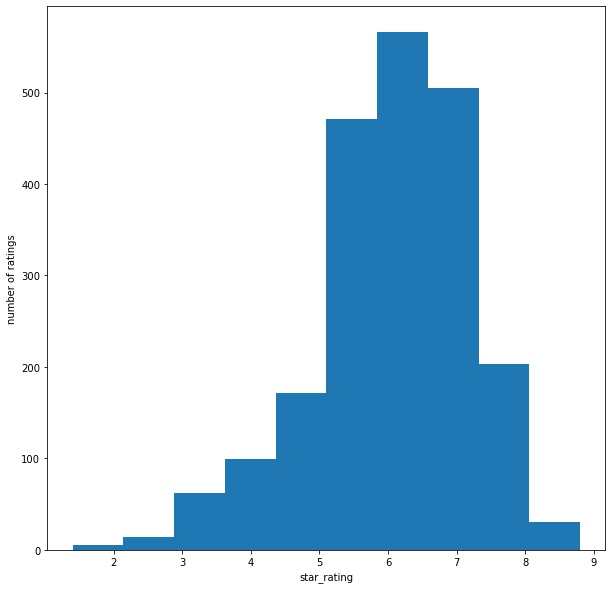

In [34]:
plt.figure(figsize=(10,10))
plt.hist(movie_df_processed["star_rating"],10)
plt.xlabel("star_rating")
plt.ylabel("number of ratings");

In [35]:
print("mean of start_rating = {} and standard deviation of start_rating is {}".format(
    movie_df_processed["star_rating"].mean(), 
    movie_df_processed["star_rating"].std())
     )

mean of start_rating = 6.054771979313587 and standard deviation of start_rating is 1.1234541096988484


In [36]:
movie_df_processed.describe()

,domesticTotalGross,runtime,budget,star_rating
count,2.127000e+03,2127.000000,2.127000e+03,2127.000000
mean,4.735307e+07,105.924777,3.726733e+07,6.054772
std,8.452938e+07,16.642327,5.070000e+07,1.123454
min,0.000000e+00,74.000000,1.000000e+04,1.400000
25%,5.862400e+04,93.000000,5.000000e+06,5.400000
50%,1.646850e+07,103.000000,1.800000e+07,6.200000
75%,5.577662e+07,116.000000,4.200000e+07,6.800000
max,9.366622e+08,209.000000,3.560000e+08,8.800000


Median and mode star value

In [37]:
movie_df_processed["star_rating"].median()

6.2

In [38]:
movie_df_processed["star_rating"].mode()

0    6.6
dtype: float64

## Outlier Detection and Removal

Going to to use [IQR](https://en.wikipedia.org/wiki/Interquartile_range) to identify outliers. Aparently linear regression is not robust to outliers (or non normailly distributed response variables). So I will remove the outliers to hopefully help the regression converge to a better model than otherwise.

Thoughts against removing outliers: The IMDB star ratings are based on user reviews. Don't know if these reflect some sort of coordinated "attack" on the movie to give it a bad review, so any low ratings are probalby _true_ samples. I may put these back if the model seems to not work well.


In [39]:
start_rating_Q1 = movie_df_processed["star_rating"].quantile(0.25)
star_rating_Q3 = movie_df_processed["star_rating"].quantile(0.75)
star_rating_IQR = star_rating_Q3 - start_rating_Q1
#John Tukey recommended values for k
k = 1.5
lower_range = start_rating_Q1 - k * star_rating_IQR
upper_range = star_rating_Q3 + k * star_rating_IQR 
print("IQR star_rating lower_range = {} upper_range = {}".format(lower_range,upper_range))

IQR star_rating lower_range = 3.300000000000001 upper_range = 8.899999999999999


Listing out what would be considered an outlier based on IQR

In [40]:
mask = (movie_df_processed["star_rating"] < lower_range) | (movie_df_processed["star_rating"]>upper_range)
movie_df_processed[mask].sort_values(["star_rating"])

,title,directlink_url,domesticTotalGross,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,budget,star_rating
2512,Kirk Cameron's Saving Christmas,http://www.imdb.com/title/tt4009460/,2783970,PG,Darren Doane,14 November 2014,Comedy,79,Kirk Cameron,Darren Doane,Bridgette Cameron,500000,1.4
2324,Foodfight!,http://www.imdb.com/title/tt0249516/,0,PG,Lawrence Kasanoff,12 February 2013,Animation,91,Hilary Duff,Haylie Duff,Charlie Sheen,65000000,1.5
3759,The Life Zone,http://www.imdb.com/title/tt1786714/,0,PG-13,Rod Weber,10 June 2011,Horror,81,Robert Loggia,Lindsey Haun,Martin Kove,1500000,1.9
3934,Snow White: A Deadly Summer,http://www.imdb.com/title/tt2149137/,0,PG-13,David DeCoteau,16 March 2012,Horror,83,Shanley Caswell,Maureen McCormick,Eric Roberts,1000000,2.1
3516,American Idiots,http://www.imdb.com/title/tt1698651/,0,R,Robert Taleghany,18 June 2013,Comedy,92,Jeffrey T. Schoettlin,Sean Muramatsu,Caroline D'Amore,750000,2.1
3935,Billy the Kid,http://www.imdb.com/title/tt2935888/,0,PG-13,Christopher Forbes,27 August 2013,Action,80,Dan Beck,Christopher Bowman,Graye Bumgardner,500000,2.2
2270,Paranormal Whacktivity,http://www.imdb.com/title/tt1757831/,0,R,Roger Roth,3 July 2018,Comedy,89,William Patrick Riley,Sasha Formoso,Damatri Crayton,360000,2.3
3051,Abelar: Tales of an Ancient Empire,http://www.imdb.com/title/tt1136688/,0,R,Albert Pyun,31 July 2010,Action,86,Inbar Lavi,Sasha Mitchell,Kevin Sorbo,1000000,2.4
2861,Apartment 1303 3D,http://www.imdb.com/title/tt1540767/,0,R,Michael Taverna,25 July 2013,Horror,85,Mischa Barton,Julianne Michelle,Rebecca De Mornay,5000000,2.5
3253,Hansel & Gretel: Warriors of Witchcraft,http://www.imdb.com/title/tt2381962/,0,PG-13,David DeCoteau,22 January 2013,Action,83,Fivel Stewart,Booboo Stewart,Eric Roberts,1000000,2.5


There are quite a few outliers according to the IQR method. I will remove them from the data frame

In [41]:
mask = (movie_df_processed["star_rating"] >= lower_range) & (movie_df_processed["star_rating"] <= upper_range)

The models do better with this "outlier data" so keeping it in the dataframe.

In [42]:
#movie_df_processed = movie_df_processed[mask]

In [43]:
#just confirming things got removed
movie_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2127 entries, 0 to 3994
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               2127 non-null   object 
 1   directlink_url      2127 non-null   object 
 2   domesticTotalGross  2127 non-null   int64  
 3   rating              2127 non-null   object 
 4   director            2127 non-null   object 
 5   releaseDate         2127 non-null   object 
 6   genre               2127 non-null   object 
 7   runtime             2127 non-null   int64  
 8   cast1               2127 non-null   object 
 9   cast2               2127 non-null   object 
 10  cast3               2127 non-null   object 
 11  budget              2127 non-null   int64  
 12  star_rating         2127 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 232.6+ KB


In [44]:
#len(movie_df_processed["director"].value_counts())

In [45]:
#len(movie_df_processed["genre"].value_counts())

In [46]:
#len(movie_df_processed["cast1"].value_counts())

In [47]:
#len(movie_df_processed["cast2"].value_counts())

In [48]:
#len(movie_df_processed["cast3"].value_counts())

Convert data into a format that can be used in a linear model

In [49]:
movie_df_processed["releaseDate"] = pd.to_datetime(movie_df_processed["releaseDate"])

<ipython-input-49-4bf70c8faa1e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df_processed["releaseDate"] = pd.to_datetime(movie_df_processed["releaseDate"])


In [50]:
#movie_df_processed.head()

In [51]:
#type(movie_df_processed.iloc[0,5])

In [52]:
movie_df_processed["releaseMonth"] = movie_df_processed["releaseDate"].dt.month_name()
movie_df_processed["releaseYear"] = movie_df_processed["releaseDate"].dt.year

#save for a different processing for a second model
movie_df_processed2 = movie_df_processed.copy()

<ipython-input-52-386511b3618f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df_processed["releaseMonth"] = movie_df_processed["releaseDate"].dt.month_name()
<ipython-input-52-386511b3618f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df_processed["releaseYear"] = movie_df_processed["releaseDate"].dt.year


In [53]:
movie_df_processed.head()

,title,directlink_url,domesticTotalGross,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,budget,star_rating,releaseMonth,releaseYear
0,On the Basis of Sex,http://www.imdb.com/title/tt4669788/,24704837,PG-13,Mimi Leder,2019-01-11,Biography,120,Felicity Jones,Armie Hammer,Justin Theroux,20000000,7.1,January,2019
1,The Gentlemen,http://www.imdb.com/title/tt8367814/,36471795,R,Guy Ritchie,2020-01-24,Action,113,Matthew McConaughey,Charlie Hunnam,Michelle Dockery,22000000,7.9,January,2020
2,Knives Out,http://www.imdb.com/title/tt8946378/,165363234,PG-13,Rian Johnson,2019-11-27,Comedy,130,Daniel Craig,Chris Evans,Ana de Armas,40000000,7.9,November,2019
3,Bastille Day,http://www.imdb.com/title/tt2368619/,50269,R,James Watkins,2016-11-18,Action,92,Idris Elba,Richard Madden,Charlotte Le Bon,20000000,6.3,November,2016
4,Joker,http://www.imdb.com/title/tt7286456/,335451311,R,Todd Phillips,2019-10-04,Crime,122,Joaquin Phoenix,Robert De Niro,Zazie Beetz,55000000,8.5,October,2019


A plot to see how `star_rating` responds to `releaseDate`

<ipython-input-54-4ca4594eb594>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df_processed.sort_values(["releaseDate"],inplace=True)


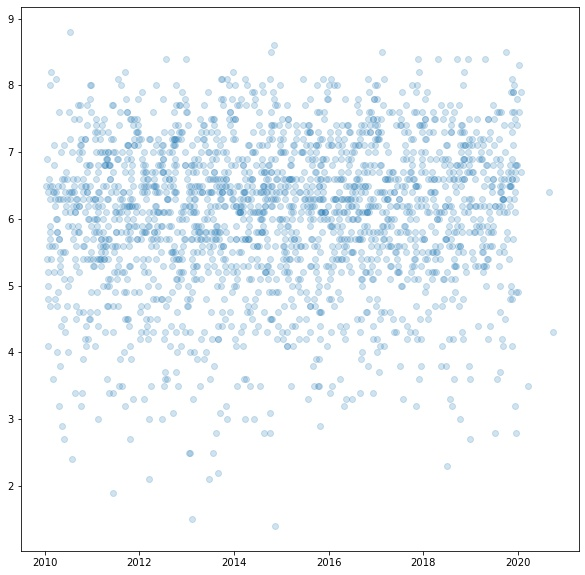

In [54]:
movie_df_processed.sort_values(["releaseDate"],inplace=True)
plt.figure(figsize=(10,10))
plt.scatter(movie_df_processed["releaseDate"],movie_df_processed["star_rating"],alpha=0.2)

`star_rating` does not seem to respond to releaseDate linearly so I will be not using it in the model.

In [55]:
#avg star rating per release Month
movie_avg_star_per_relmonth_df = movie_df_processed.groupby(["releaseMonth"])["star_rating"].mean().reset_index()
movie_avg_star_per_relmonth_df.sort_values("star_rating",ascending=False)

,releaseMonth,star_rating
9,November,6.369730
2,December,6.291176
6,June,6.058084
1,August,6.056000
4,January,6.039779
3,February,6.000662
11,September,6.000000
10,October,5.994286
5,July,5.984713
0,April,5.980105


It seems on average `star_rating` seems to be higher in some months more than others so I will include `releaseMonth` in the model.

NOTE: Need to do a weighted rating for crew/cast. Mult avg rating by number of times name appears in DF

In [56]:
#movie_avg_star_per_director_df = movie_df_processed.groupby(["director"])["star_rating"].mean().reset_index()
#movie_avg_star_per_director_df.sort_values("star_rating",ascending=False).head(50)


"Bob Persichetti" is a one-hit wonder. So can't just go by average alone. Maybe `avg * number_of_movies * oscar_factor`

In [57]:
#movie_df_processed[ movie_df_processed["director"] == "Bob Persichetti"  ]["title"].count()

In [58]:
movie_df_processed.columns

Index(['title', 'directlink_url', 'domesticTotalGross', 'rating', 'director',
       'releaseDate', 'genre', 'runtime', 'cast1', 'cast2', 'cast3', 'budget',
       'star_rating', 'releaseMonth', 'releaseYear'],
      dtype='object')

I am attempting to create a model that will predict star rating on opening day of the movie. So I cannot use features that become available after opening day. So I will drop these features:
* `domesticTotalGross`

In [59]:
movie_df_processed.drop(["domesticTotalGross"],inplace=True,axis=1)

/Users/magreen/Anaconda3-2020_07/envs/tensorflow_in_practice/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [60]:
movie_df_processed.columns

Index(['title', 'directlink_url', 'rating', 'director', 'releaseDate', 'genre',
       'runtime', 'cast1', 'cast2', 'cast3', 'budget', 'star_rating',
       'releaseMonth', 'releaseYear'],
      dtype='object')

Correlation Matrix

In [61]:
movie_df_processed.corr()

,runtime,budget,star_rating,releaseYear
runtime,1.000000,0.455620,0.519328,0.112327
budget,0.455620,1.000000,0.308271,0.018657
star_rating,0.519328,0.308271,1.000000,0.072808
releaseYear,0.112327,0.018657,0.072808,1.000000


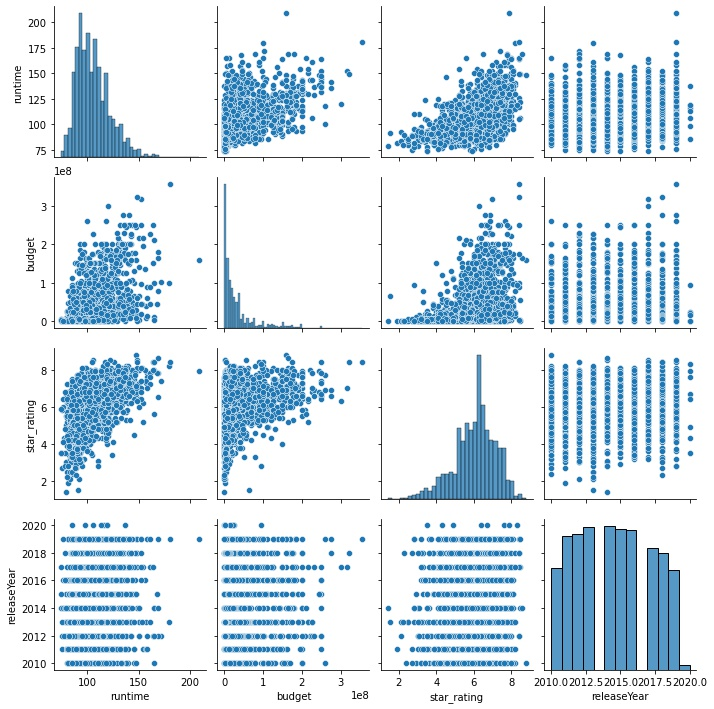

In [62]:
sns.pairplot(movie_df_processed)

Action Notes:
* Create a new feature $log(budget)$



Plotting Rating versus budget

In [63]:

rating_budget_series = movie_df_processed[["star_rating","budget"]]
rating_budget_series.sort_values(["budget"],inplace=True)
#rating_budget_series

<ipython-input-63-d6e8cc662c66>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_budget_series.sort_values(["budget"],inplace=True)


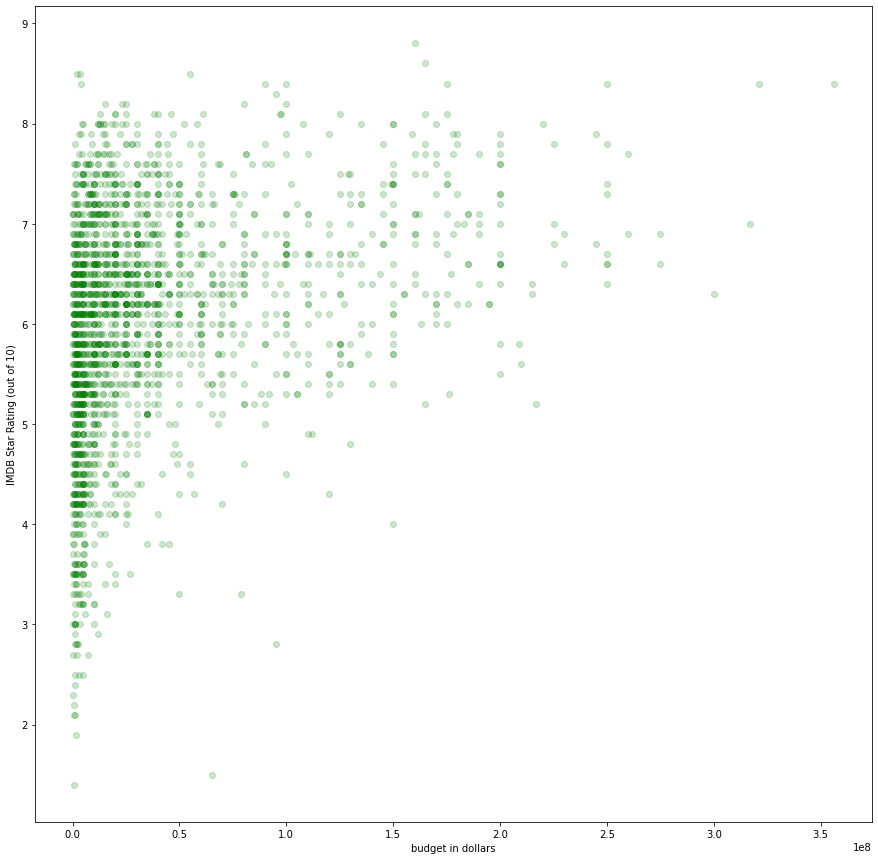

In [64]:
plt.figure(figsize=(15,15))
plt.scatter(rating_budget_series["budget"],rating_budget_series["star_rating"],alpha=0.2,color="green")
plt.xlabel("budget in dollars")
plt.ylabel("IMDB Star Rating (out of 10)");

Notes about graph
* unless budget is over \$50M it does not seem to inform what the rating will be
* After budget gets to \$50M it looks like star rating is a logarithmic function of budget

<ipython-input-65-d7ab0ed6e3bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_relyear_series.sort_values(["releaseYear"],inplace=True)


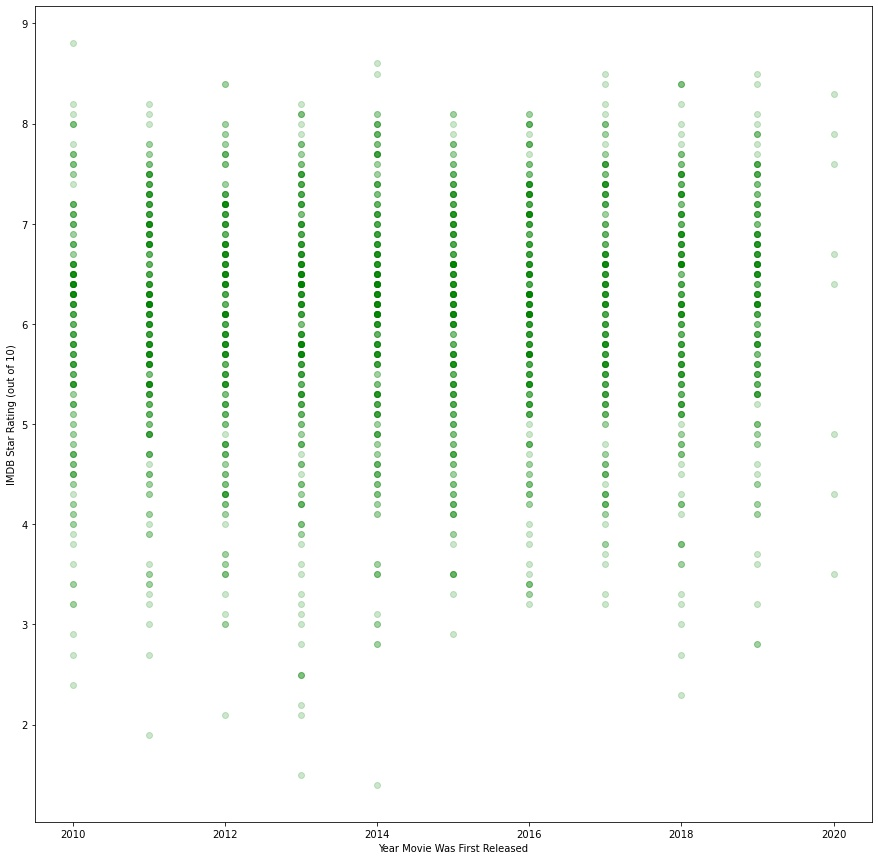

In [65]:
rating_relyear_series = movie_df_processed[["star_rating","releaseYear"]]
rating_relyear_series.sort_values(["releaseYear"],inplace=True)
plt.figure(figsize=(15,15))
plt.scatter(rating_relyear_series["releaseYear"],rating_relyear_series["star_rating"],alpha=0.2,color="green")
plt.xlabel("Year Movie Was First Released")
plt.ylabel("IMDB Star Rating (out of 10)");
#rating_budget_series

Notes on graph
* release year doesn't affect IMDB score. Seems with respect to year, IMDB score is random


In [66]:
#sns.pairplot(movie_df_processed)

## Creating One-Hot Encoded Variables
I plan on including categorical data in the model. So as to not bake in meaning into these values that does not exist I will make them [one-hot encoded](https://en.wikipedia.org/wiki/One-hot) features.

one hot encode `releaseMonth`, `genre`, and `rating`

In [67]:
one_hot_encoded_release_month_series = pd.get_dummies(movie_df_processed["releaseMonth"],drop_first=True)


In [68]:
movie_df_processed = pd.concat([movie_df_processed, one_hot_encoded_release_month_series], axis=1)

In [69]:
one_hot_encoded_genre_series = pd.get_dummies(movie_df_processed["genre"],drop_first=True)

In [70]:
movie_df_processed = pd.concat([movie_df_processed, one_hot_encoded_genre_series], axis=1)

In [71]:
one_hot_encoded_mpaa_rating = pd.get_dummies(movie_df_processed["rating"],drop_first=True)

In [72]:
movie_df_processed = pd.concat([movie_df_processed, one_hot_encoded_mpaa_rating], axis=1)

In [73]:
movie_df_processed.columns

Index(['title', 'directlink_url', 'rating', 'director', 'releaseDate', 'genre',
       'runtime', 'cast1', 'cast2', 'cast3', 'budget', 'star_rating',
       'releaseMonth', 'releaseYear', 'August', 'December', 'February',
       'January', 'July', 'June', 'March', 'May', 'November', 'October',
       'September', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'Western', 'PG', 'PG-13',
       'R'],
      dtype='object')

Correlation Matrix to try to understand which of these features highly linearly correlates with `star_rating`

In [74]:
movie_for_modelling_corr_df = movie_df_processed.corr()

#I sort the "star_rating" column so I can quickly see which features have the highest correlation to `star_rating`
movie_for_modelling_corr_df.sort_values(["star_rating"],ascending=False,inplace=True)
movie_for_modelling_corr_df = movie_for_modelling_corr_df.reset_index()
#movie_for_modelling_corr_df.rename(columns={"index":"name"},inplace=True)
movie_for_modelling_corr_df

,index,runtime,budget,star_rating,releaseYear,August,December,February,January,July,...,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,Western,PG,PG-13,R
0,star_rating,0.519328,0.308271,1.000000,0.072808,0.000352,0.062034,-0.013317,-0.004071,-0.017609,...,0.047215,0.031628,-0.000717,0.009429,-0.006850,-0.087795,-0.058985,0.033523,0.098412,-0.118266
1,runtime,1.000000,0.455620,0.519328,0.112327,-0.055276,0.128040,-0.011404,0.015658,-0.021094,...,0.056148,0.013723,-0.008112,-0.010924,-0.005116,-0.052150,-0.028579,-0.105033,0.209127,-0.123765
2,budget,0.455620,1.000000,0.308271,0.018657,-0.061223,0.077325,-0.014689,-0.069251,0.076573,...,-0.015090,-0.004276,-0.007440,-0.013931,-0.014662,-0.047196,-0.015518,0.187759,0.244628,-0.365220
3,Biography,0.188886,-0.080940,0.211000,0.104204,0.013784,0.082565,-0.015024,0.010568,-0.052187,...,-0.006123,-0.010610,-0.010610,-0.008661,-0.006123,-0.019402,-0.006123,-0.021520,0.038022,-0.020565
4,PG-13,0.209127,0.244628,0.098412,-0.017445,-0.002494,0.020351,0.065933,-0.018468,-0.030126,...,-0.015694,-0.027196,0.025559,0.010098,0.029971,-0.049734,0.029971,-0.301712,1.000000,-0.734944
5,November,0.084320,0.079773,0.086549,0.031360,-0.099434,-0.090968,-0.085321,-0.094130,-0.087132,...,-0.006694,-0.011600,-0.011600,-0.009469,-0.006694,-0.021213,-0.006694,0.045102,-0.002038,-0.029818
6,Animation,-0.168824,0.237987,0.080729,0.038052,-0.009580,-0.005022,0.011144,-0.045805,0.054873,...,-0.005327,-0.009230,-0.009230,-0.007535,-0.005327,-0.016880,-0.005327,0.554762,-0.164902,-0.237260
7,releaseYear,0.112327,0.018657,0.072808,1.000000,0.018199,0.020259,-0.007850,0.022896,-0.017964,...,0.020318,-0.015129,0.003175,0.006328,-0.011371,-0.023482,-0.003449,0.025559,-0.017445,-0.000750
8,Drama,0.044597,-0.201717,0.067078,-0.013196,0.009541,-0.019785,0.009668,0.011715,-0.056558,...,-0.010115,-0.017528,-0.017528,-0.014308,-0.010115,-0.032054,-0.010115,-0.025143,0.047557,-0.029331
9,December,0.128040,0.077325,0.062034,0.020259,-0.094952,1.000000,-0.081475,-0.089887,-0.083204,...,-0.006392,-0.011077,0.035120,-0.009042,-0.006392,-0.020257,-0.006392,0.013783,0.020351,-0.028848


# Baseline Model

I kept around some fields to help me understand the data. I will now create the dataframe that will be used to fit the model

```python

movie_for_modeling_df = movie_df_processed[['star_rating','runtime','budget', 'August', 'December', 'February','January', 'July', 'June', 'March',
                                            'May', 'November', 'October','September', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
                                            'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Sport', 'Thriller', 'Western', 'PG', 'PG-13', 'R']]

```

In [75]:
#movie_for_modeling_df = movie_df_processed[['star_rating','runtime','budget','August', 'December', 'February',
#                                           'January', 'July', 'June', 'March', 'May', 'November', 'October','September',
#                                           'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime','Drama', 'Family',
#                                           'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Sport', 'Thriller', 'Western', 'PG', 'PG-13','R']]

#just going to include the top 3 features that have the largest correlation (by magnitude)
movie_for_modeling_df = movie_df_processed[["star_rating","runtime","budget","Biography","Horror","R","Thriller"]]


In [76]:
movie_for_modeling_df.head()

,star_rating,runtime,budget,Biography,Horror,R,Thriller
1077,6.5,100,19000000,0,0,0,0
465,6.9,118,80000000,0,0,1,0
1754,5.4,94,28000000,0,0,0,0
2400,6.4,106,31000000,0,0,0,0
525,5.2,100,26000000,0,0,1,0


In [77]:
Y = movie_for_modeling_df["star_rating"]
X = movie_for_modeling_df.drop("star_rating",axis=1)


In [78]:
#Creating a 80 train / 10 validation / 10 test split
X_train_val,X_test, Y_train_val,Y_test = train_test_split(X, Y, test_size=0.10, random_state=RANDOM_STATE)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.111, random_state=RANDOM_STATE)

In [79]:
print(X_train.shape,X_val.shape,X_test.shape)

(1701, 6) (213, 6) (213, 6)


In [80]:
print(Y_train.shape,Y_val.shape,Y_test.shape)

(1701,) (213,) (213,)


In [81]:
baseline_model = LinearRegression()
baseline_model.fit(X_train,Y_train)
train_baseline_score = baseline_model.score(X_train,Y_train)
val_baseline_score = baseline_model.score(X_val,Y_val)
print("train baseline score {} validation baseline score {}".format(train_baseline_score, val_baseline_score))

train baseline score 0.31372638965423627 validation baseline score 0.2510754536262563


Looking at coefficients of the model


In [82]:
list(zip(X_train.columns, baseline_model.coef_))

[('runtime', 0.027941126684669138),
 ('budget', 2.7279782765993833e-09),
 ('Biography', 0.6481212857470066),
 ('Horror', -0.5036538604013421),
 ('R', -0.0018603067275942912),
 ('Thriller', -0.9187429245178519)]

In [83]:
baseline_model.intercept_

3.0051034627193967

### Doing a K-fold cross validation


In [84]:
baseline_model = LinearRegression()
kfold_object = KFold(n_splits=5, shuffle=True,random_state=RANDOM_STATE)
baseline_model_cv_results = cross_validate(baseline_model, X_train_val, Y_train_val,scoring=["r2", "neg_mean_squared_error"],cv=kfold_object)
#baseline_model_cv_results_mean = np.mean(baseline_model_cv_results)
#baseline_model_cv_results_stddev = np.std(baseline_model_cv_results)

#for debugging
#print(baseline_model_cv_results)
print("average validation R2 = ",np.mean(baseline_model_cv_results["test_r2"]))
print("average validation MSE = ",-1*np.mean(baseline_model_cv_results["test_neg_mean_squared_error"]))
#print("scores -> {}\nmean -> {}\nstandard deviation -> {}\n".format(baseline_model_cv_results,baseline_model_cv_results_mean,baseline_model_cv_results_stddev))


average validation R2 =  0.29419132538848725
average validation MSE =  0.8823934532968118


## Adding Features to Improve the Model

I hypothesize that the director and cast have a strong influence on the `star_rating`. I don't know of a way to directly correlate names to `star_rating` and doing a one-hot encoding and generating a correlation matrix is not computationally feasible for me.

So I am creating a feature called `star_power` that I hope is linearly related to `star_rating` and is a function of the names in  the `director` column.

I will then use this feature along with the others to hopefully train a better model.

If director helps I will factor in cast as well.

Psuedocode equation for star power:

```
star_power["movie"] = Number_of_Oscars["director"]
```


In [85]:
#Names of nominees or winners for Best Director from 2010-2019. Names are repeated because said name won the award more than once. Names appear once per instance of nominator or award.
Best_Directors = ["Tom Hooper", "Darren Aronofsky",
                  "Joel Coen", "Ethan Coen",
                  "David Fincher", "David O. Russell",
                  "Woody Allen","Michel Hazanavicius", "Terrence Malick",
                  "Alexander Payne", "Martin Scorsese",
                  "Michael Haneke", "David O. Russell","Ang Lee",
                  "Steven Spielberg", "Benh Zeitlin",
                  "Steve McQueen", "Alexander Payne","Alfonso Cuarón",
                  "David O. Russell", "Martin Scorsese","Alejandro G. Iñárritu",
                  "Wes Anderson","Richard Linklater","Alejandro G. Iñárritu",
                  "Bennet Miller","Morten Tyldum","Alejandro G. Iñárritu",
                  "Lenny Abrahamson","Tom McCarthy",
                  "Adam McKay", "George Miller",
                  "Mel Gibson", "Barry Jenkins","Damien Chazelle"
                  "Kenneth Lonegran", "Denis Villeneuve","Guillermo del Toro"
                  "Paul Thomas Anderson", "Greta Gerwig",
                  "Christopher Nolan","Jordan Peele","Alfonso Cuarón"
                  "Yorgos Lanthimos","Spike Lee",
                  "Adam McKay","Pawel Pawlikowski","Bong Joon-ho"
                  "Sam Mendes","Todd Phillips",
                  "Martin Scorsese", "Quentin Tarantino"]
                  
                  


In [86]:

##Creating a new feature called star_power

director_names =  movie_df_processed["director"]
director_names = set(director_names)
movie_df_processed["star_power"] = 0


for director_name in director_names:

    director_count = movie_df_processed[ movie_df_processed["director"] == director_name  ]["title"].count()
    total_star_rating = movie_df_processed[ movie_df_processed["director"] == director_name  ]["star_rating"].sum()
    avg_star_rating = total_star_rating/director_count
    
    movie_df_processed.loc[ movie_df_processed["director"] == director_name,"star_power" ] = Best_Directors.count( director_name )

In [87]:
#movie_df_processed["star_power"] = movie_df_processed["star_rating"] + Best_Directors.count( movie_df_processed["director"] )
movie_df_processed.sort_values(["star_power"],ascending=False).head(5)

,title,directlink_url,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,...,Mystery,Romance,Sci-Fi,Sport,Thriller,Western,PG,PG-13,R,star_power
281,Birdman or (The Unexpected Virtue of Ignorance),http://www.imdb.com/title/tt2562232/,R,Alejandro G. Iñárritu,2014-11-14,Comedy,119,Michael Keaton,Zach Galifianakis,Edward Norton,...,0,0,0,0,0,0,0,0,1,3
85,Shutter Island,http://www.imdb.com/title/tt1130884/,R,Martin Scorsese,2010-02-19,Mystery,138,Leonardo DiCaprio,Emily Mortimer,Mark Ruffalo,...,1,0,0,0,0,0,0,0,1,3
54,The Irishman,http://www.imdb.com/title/tt1302006/,R,Martin Scorsese,2019-11-27,Biography,209,Robert De Niro,Al Pacino,Joe Pesci,...,0,0,0,0,0,0,0,0,1,3
16,The Wolf of Wall Street,http://www.imdb.com/title/tt0993846/,R,Martin Scorsese,2013-12-25,Biography,180,Leonardo DiCaprio,Jonah Hill,Margot Robbie,...,0,0,0,0,0,0,0,0,1,3
2064,Accidental Love,http://www.imdb.com/title/tt1137470/,PG-13,David O. Russell,2015-02-10,Comedy,100,Jessica Biel,Raymond L. Brown Jr.,Jenny Gulley,...,0,0,0,0,0,0,0,1,0,3


In [88]:
movie_df_processed.columns

Index(['title', 'directlink_url', 'rating', 'director', 'releaseDate', 'genre',
       'runtime', 'cast1', 'cast2', 'cast3', 'budget', 'star_rating',
       'releaseMonth', 'releaseYear', 'August', 'December', 'February',
       'January', 'July', 'June', 'March', 'May', 'November', 'October',
       'September', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'Western', 'PG', 'PG-13', 'R',
       'star_power'],
      dtype='object')

I'm doing this to compare the star power number between a director that has one at least one Oscar and a director that has not.

In [89]:
mask = (movie_df_processed["director"]=="Alejandro G. Iñárritu") | (movie_df_processed["director"]=="Mimi Leder")

movie_df_processed[mask]

,title,directlink_url,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,...,Mystery,Romance,Sci-Fi,Sport,Thriller,Western,PG,PG-13,R,star_power
281,Birdman or (The Unexpected Virtue of Ignorance),http://www.imdb.com/title/tt2562232/,R,Alejandro G. Iñárritu,2014-11-14,Comedy,119,Michael Keaton,Zach Galifianakis,Edward Norton,...,0,0,0,0,0,0,0,0,1,3
93,The Revenant,http://www.imdb.com/title/tt1663202/,R,Alejandro G. Iñárritu,2016-01-08,Action,156,Leonardo DiCaprio,Tom Hardy,Will Poulter,...,0,0,0,0,0,0,0,0,1,3
0,On the Basis of Sex,http://www.imdb.com/title/tt4669788/,PG-13,Mimi Leder,2019-01-11,Biography,120,Felicity Jones,Armie Hammer,Justin Theroux,...,0,0,0,0,0,0,0,1,0,0


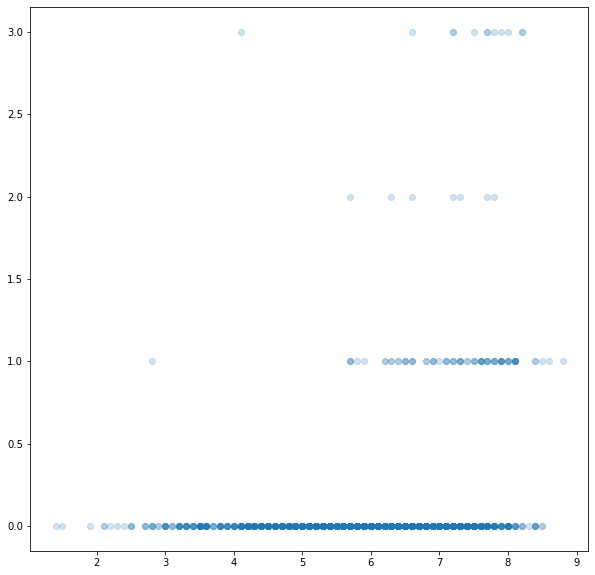

In [90]:
#TODO: Add title and labels for X and Y axes
movie_df_processed.sort_values(["star_rating"],inplace=True)
plt.figure(figsize=(10,10))
plt.scatter(movie_df_processed["star_rating"],movie_df_processed["star_power"],alpha=0.2)

Is somewhat linear

Top average star powers and corresponding names of the directors.

In [91]:
movieProcessedAVGStarPowerPerDirector = movie_df_processed.groupby(["director"])["star_power"].mean().reset_index()
movieProcessedAVGStarPowerPerDirector.sort_values(["star_power"],inplace=True,ascending=False)
movieProcessedAVGStarPowerPerDirector.head(10)

,director,star_power
24,Alejandro G. Iñárritu,3
836,Martin Scorsese,3
305,David O. Russell,3
36,Alexander Payne,2
8,Adam McKay,2
1271,Todd Phillips,1
1063,Richard Linklater,1
1043,Quentin Tarantino,1
325,Denis Villeneuve,1
40,Alfonso Cuarón,1


<BarContainer object of 10 artists>

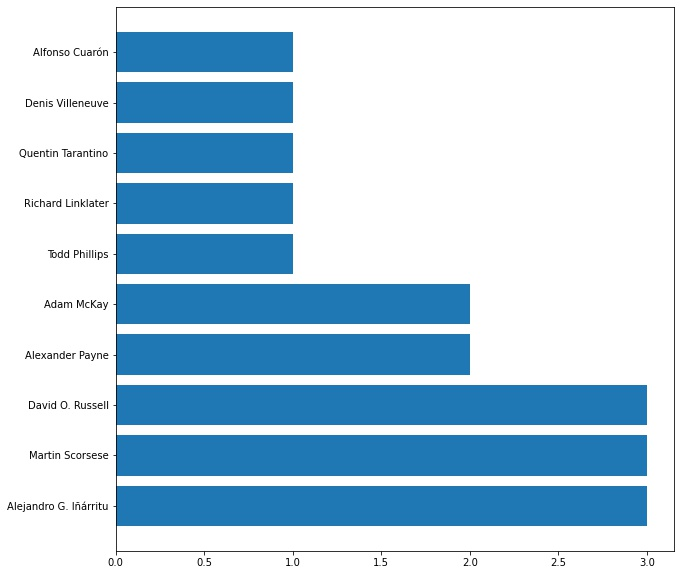

In [92]:
#top 10 directors by star power
plt.figure(figsize=(10,10))
plt.barh(movieProcessedAVGStarPowerPerDirector.iloc[:10,0],movieProcessedAVGStarPowerPerDirector.iloc[:10,1])

Plot appears to make sense. 

In [93]:
#bottom 10 directors by star power
#plt.figure(figsize=(10,10))
#plt.barh(movieProcessedAVGStarPowerPerDirector.iloc[-10:,0],movieProcessedAVGStarPowerPerDirector.iloc[-10:,1])

In [94]:
#movie_df_processed.head(5)

In [95]:

#TODO: If you need to incorporate actors into star power number start here
#movie_avg_star_per_cast1_df = movie_df_processed.groupby(["cast1"])["star_rating"].mean().reset_index()
#movie_avg_star_per_cast1_df.sort_values("star_rating",ascending=False).head(50)

I looked at the `star_rating` vs `budget` plot and it looks logarithmic to me so will add that feature instead

In [96]:

movie_df_processed["log_budget"] = movie_df_processed["budget"].apply(lambda x : math.log(x))

In [97]:
movie_df_processed.columns

Index(['title', 'directlink_url', 'rating', 'director', 'releaseDate', 'genre',
       'runtime', 'cast1', 'cast2', 'cast3', 'budget', 'star_rating',
       'releaseMonth', 'releaseYear', 'August', 'December', 'February',
       'January', 'July', 'June', 'March', 'May', 'November', 'October',
       'September', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'Western', 'PG', 'PG-13', 'R',
       'star_power', 'log_budget'],
      dtype='object')

In [98]:
movie_df_processed.head()

,title,directlink_url,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,...,Romance,Sci-Fi,Sport,Thriller,Western,PG,PG-13,R,star_power,log_budget
2512,Kirk Cameron's Saving Christmas,http://www.imdb.com/title/tt4009460/,PG,Darren Doane,2014-11-14,Comedy,79,Kirk Cameron,Darren Doane,Bridgette Cameron,...,0,0,0,0,0,1,0,0,0,13.122363
2324,Foodfight!,http://www.imdb.com/title/tt0249516/,PG,Lawrence Kasanoff,2013-02-12,Animation,91,Hilary Duff,Haylie Duff,Charlie Sheen,...,0,0,0,0,0,1,0,0,0,17.989898
3759,The Life Zone,http://www.imdb.com/title/tt1786714/,PG-13,Rod Weber,2011-06-10,Horror,81,Robert Loggia,Lindsey Haun,Martin Kove,...,0,0,0,0,0,0,1,0,0,14.220976
3516,American Idiots,http://www.imdb.com/title/tt1698651/,R,Robert Taleghany,2013-06-18,Comedy,92,Jeffrey T. Schoettlin,Sean Muramatsu,Caroline D'Amore,...,0,0,0,0,0,0,0,1,0,13.527828
3934,Snow White: A Deadly Summer,http://www.imdb.com/title/tt2149137/,PG-13,David DeCoteau,2012-03-16,Horror,83,Shanley Caswell,Maureen McCormick,Eric Roberts,...,0,0,0,0,0,0,1,0,0,13.815511


## Model Improved `star_power`
Here I'm training a model using the new set of predictor values that include `star_power` and `log_budget` along with other features.

In [99]:
movie_for_modeling_df = movie_df_processed[['star_rating','runtime','budget', 'August', 'December', 'February','January', 'July', 'June', 'March',
                                            'May', 'November', 'October','September', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
                                            'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Sport', 'Thriller', 'PG', 'PG-13', 'R',"star_power","log_budget"]]

In [100]:
Y = movie_for_modeling_df["star_rating"]
X = movie_for_modeling_df.drop("star_rating",axis=1)


In [101]:
#hold out 20% for testing
#Creating a 80 train / 10 validation / 10 test split
X_train_val,X_test, Y_train_val,Y_test = train_test_split(X, Y, test_size=0.10, random_state=RANDOM_STATE)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.111, random_state=RANDOM_STATE)


In [102]:
model2 = LinearRegression()
model2.fit(X_train,Y_train)
train_model2_score = model2.score(X_train,Y_train)
val_model2_score = model2.score(X_val,Y_val)
print("train score {} validation score {}".format(train_model2_score, val_model2_score))

train score 0.3700061819969155 validation score 0.3673675316080649


In [103]:
print("train baseline score {} validation baseline score {}".format(train_baseline_score, val_baseline_score))

train baseline score 0.31372638965423627 validation baseline score 0.2510754536262563


I'm seeing a large improvement after adding `star_power` and `log_budget` and other features.

In [104]:
list(zip(X_train.columns, model2.coef_))

[('runtime', 0.026863186133748485),
 ('budget', 3.687729469262716e-10),
 ('August', 0.09883096188040107),
 ('December', -0.19647704012798625),
 ('February', -0.0888040865147719),
 ('January', -0.015370362248634584),
 ('July', -0.06777316613927403),
 ('June', -0.01397416389820445),
 ('March', -0.10964462389916672),
 ('May', -0.20322636869220362),
 ('November', 0.0515412910888284),
 ('October', -0.047893279870435346),
 ('September', 0.01225963153675699),
 ('Adventure', 0.36173690936623876),
 ('Animation', 0.9042407619083073),
 ('Biography', 0.7982217535391124),
 ('Comedy', 0.2794005042282441),
 ('Crime', 0.3590565940172451),
 ('Drama', 0.516332268125131),
 ('Family', -0.8019907900584528),
 ('Fantasy', -0.369596177629325),
 ('Horror', -0.04166775407634035),
 ('Music', 1.7225369508312134),
 ('Musical', 2.147670010080071),
 ('Mystery', 0.975525532638844),
 ('Romance', 0.46381511300948003),
 ('Sci-Fi', 1.0327205479155128),
 ('Sport', 0.2584021119178255),
 ('Thriller', -0.3801325755749869),
 

In [105]:
 model2.intercept_

1.3967813839352505

### Doing a K-fold cross validation


In [106]:
model2 = LinearRegression()
kfold_object = KFold(n_splits=5, shuffle=True,random_state=RANDOM_STATE)
model2_cv_results = cross_validate(model2, X_train_val, Y_train_val,scoring=["r2", "neg_mean_squared_error"],cv=kfold_object)
#baseline_model_cv_results_mean = np.mean(baseline_model_cv_results)
#baseline_model_cv_results_stddev = np.std(baseline_model_cv_results)

#for debugging
#print(baseline_model_cv_results)
print("average validation R2 = ",np.mean(model2_cv_results["test_r2"]))
print("average validation MSE = ",-1*np.mean(model2_cv_results["test_neg_mean_squared_error"]))
#print("scores -> {}\nmean -> {}\nstandard deviation -> {}\n".format(baseline_model_cv_results,baseline_model_cv_results_mean,baseline_model_cv_results_stddev))


average validation R2 =  0.3351157353057575
average validation MSE =  0.8397196506796085


Adding star power for the other cast members below

In [107]:
Best_Actor_Actress = [
    "Colin Firth",
    "Javier Bardem",
    "Jeff Bridges",
    "Jesse Eisenberg",
    "James Franco",
    "Jean Dujardin",
    "Demián Bichir",
    "George Clooney",
    "Gary Oldman",
    "Brad Pitt",
    "Daniel Day-Lewis",
    "Bradely Cooper",
    "Joaquin Phoenix",
    "Denzel Washington",
    "Matthew McConaughey",
    "Christian Bale",
    "Bruce Dern",
    "Leonardo DiCaprio",
    "Chiwetel Ejiofor",
    "Eddie Redmayne",
    "Steve Carell",
    "Bradley Cooper",
    "Benedict Cumerbatch",
    "Michael Keaton",
    "Leonardo DiCaprio",
    "Bryan Cranston",
    "Matt Damon",
    "Michael Fassbender",
    "Eddie Redmayne",
    "Casey Affleck",
    "Andrew Garfield",
    "Ryan Gosling",
    "Viggo Mortensen",
    "Denzel Washington",
    "Gary Oldman",
    "Timothée Chalamet",
    "Daniel Day-Lewis",
    "Daniel Kaluuya",
    "Denzel Washington",
    "Rami Malek",
    "Christian Bale",
    "Bradley Cooper",
    "Willem Dafoe",
    "Viggo Mortensen",
    "Joaquin Phoenix",
    "Antonio Banderas",
    "Leonardo DiCaprio",
    "Adam Driver",
    "Jonathan Pryce",
    "Natalie Portman",
    "Annette Bening",
    "Nicole Kidman",
    "Jennifer Lawrence",
    "Michelle Williams",
    "Meryl Streep",
    "Glen Close",
    "Viola Davis",
    "Rooney Mara",
    "Michelle Williams",
    "Jennifer Lawrence",
    "Jessica Chastain",
    "Emmanuelle Riva",
    "Quvenzhané Wallis",
    "Naomi Watts",
    "Cate Blanchett",
    "Amy Adams",
    "Sandra Bullock",
    "Judi Dench",
    "Meryl Streep",
    "Julianne Moore",
    "Marion Cotillard",
    "Felicity Jones",
    "Rosamund Pike",
    "Reese Witherspoon",
    "Brie Larson",
    "Cate Blanchett",
    "Jennifer Lawrence",
    "Charlotte Rampling",
    "Saoirse Ronan",
    "Emma Stone",
    "Isabelle Huppert",
    "Ruth Negga",
    "Natalie Portman",
    "Meryl Streep",
    "Frances McDormand",
    "Sally Hawkins",
    "Margot Robbie",
    "Saoirse Ronan",
    "Meryl Streep",
    "Olivia Colman",
    "Yalitza Aparicio",
    "Glenn Close",
    "Lady Gaga",
    "Melissa McCarthy",
    "Renée Zellweger",
    "Cynthia Erivo",
    "Scarlette Johansson",
    "Saoirse Ronan",
    "Charlize Theron"
]

In [108]:

features_to_process = ["cast1","cast2","cast3"]

for feature in features_to_process:
    actor_names = movie_df_processed[feature]
    #now it's a unique list of names from the column "feature"
    actor_names = set(actor_names)
    movie_df_processed["{}_starpower".format(feature)] = 0
    
    for actor_name in actor_names:
        movie_df_processed.loc[movie_df_processed[feature] == actor_name,"{}_starpower".format(feature)]  = Best_Actor_Actress.count(actor_name)


In [109]:
movie_df_processed

,title,directlink_url,rating,director,releaseDate,genre,runtime,cast1,cast2,cast3,...,Thriller,Western,PG,PG-13,R,star_power,log_budget,cast1_starpower,cast2_starpower,cast3_starpower
2512,Kirk Cameron's Saving Christmas,http://www.imdb.com/title/tt4009460/,PG,Darren Doane,2014-11-14,Comedy,79,Kirk Cameron,Darren Doane,Bridgette Cameron,...,0,0,1,0,0,0,13.122363,0,0,0
2324,Foodfight!,http://www.imdb.com/title/tt0249516/,PG,Lawrence Kasanoff,2013-02-12,Animation,91,Hilary Duff,Haylie Duff,Charlie Sheen,...,0,0,1,0,0,0,17.989898,0,0,0
3759,The Life Zone,http://www.imdb.com/title/tt1786714/,PG-13,Rod Weber,2011-06-10,Horror,81,Robert Loggia,Lindsey Haun,Martin Kove,...,0,0,0,1,0,0,14.220976,0,0,0
3516,American Idiots,http://www.imdb.com/title/tt1698651/,R,Robert Taleghany,2013-06-18,Comedy,92,Jeffrey T. Schoettlin,Sean Muramatsu,Caroline D'Amore,...,0,0,0,0,1,0,13.527828,0,0,0
3934,Snow White: A Deadly Summer,http://www.imdb.com/title/tt2149137/,PG-13,David DeCoteau,2012-03-16,Horror,83,Shanley Caswell,Maureen McCormick,Eric Roberts,...,0,0,0,1,0,0,13.815511,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Whiplash,http://www.imdb.com/title/tt2582802/,R,Damien Chazelle,2014-10-15,Drama,106,Miles Teller,J.K. Simmons,Melissa Benoist,...,0,0,0,0,1,0,15.009433,0,0,0
1842,Disney's Newsies: The Broadway Musical!,http://www.imdb.com/title/tt6346162/,PG,Jeff Calhoun,2017-02-16,Musical,149,Jeremy Jordan,Kara Lindsay,Ben Fankhauser,...,0,0,1,0,0,0,14.508658,0,0,0
4,Joker,http://www.imdb.com/title/tt7286456/,R,Todd Phillips,2019-10-04,Crime,122,Joaquin Phoenix,Robert De Niro,Zazie Beetz,...,0,0,0,0,1,1,17.822844,2,0,0
6,Interstellar,http://www.imdb.com/title/tt0816692/,PG-13,Christopher Nolan,2014-11-07,Adventure,169,Matthew McConaughey,Anne Hathaway,Jessica Chastain,...,0,0,0,1,0,1,18.921456,1,0,1


## Trying another improvement with more features

Added features `cast[1-3]_starpower`

OK Try to train a third model

In [110]:
movie_for_modeling_df = movie_df_processed[['star_rating','runtime','budget', 'August', 'December', 'February','January', 'July', 'June', 'March',
                                            'May', 'November', 'October','September', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
                                            'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Sport',
                                            'Thriller', 'PG', 'PG-13', 'R',"star_power","cast1_starpower","cast2_starpower","cast3_starpower","log_budget"]]

In [111]:
Y = movie_for_modeling_df["star_rating"]
X = movie_for_modeling_df.drop("star_rating",axis=1)

In [112]:
#hold out 20% for testing
#Creating a 80 train / 10 validation / 10 test split
X_train_val,X_test, Y_train_val,Y_test = train_test_split(X, Y, test_size=0.10, random_state=RANDOM_STATE)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.111, random_state=RANDOM_STATE)

print("X_train.shape",X_train.shape)
print("X_val.shape",X_val.shape)
print("X_test.shape",X_test.shape)
print("Y_train.shape",Y_train.shape)
print("Y_val.shape",Y_val.shape)
print("Y_test.shape",Y_test.shape)

X_train.shape (1701, 37)
X_val.shape (213, 37)
X_test.shape (213, 37)
Y_train.shape (1701,)
Y_val.shape (213,)
Y_test.shape (213,)


In [113]:
model3 = LinearRegression()
model3.fit(X_train,Y_train)
train_model3_score = model3.score(X_train,Y_train)
val_model3_score = model3.score(X_val,Y_val)
print("train score {} validation score {}".format(train_model3_score, val_model3_score))

train score 0.3754914068706692 validation score 0.3724397340859753


In [114]:
print("train baseline score {} validation baseline score {}".format(train_baseline_score, val_baseline_score))
print("train score {} validation score {}".format(train_model2_score, val_model2_score))

train baseline score 0.31372638965423627 validation baseline score 0.2510754536262563
train score 0.3700061819969155 validation score 0.3673675316080649


### Doing a K-fold cross validation


In [115]:
model3 = LinearRegression()
kfold_object = KFold(n_splits=5, shuffle=True,random_state=RANDOM_STATE)
model3_cv_results = cross_validate(model3, X_train_val, Y_train_val,scoring=["r2", "neg_mean_squared_error"],cv=kfold_object)
#baseline_model_cv_results_mean = np.mean(baseline_model_cv_results)
#baseline_model_cv_results_stddev = np.std(baseline_model_cv_results)

#for debugging
#print(baseline_model_cv_results)
print("average validation R2 = ",np.mean(model3_cv_results["test_r2"]))
print("average validation MSE = ",-1*np.mean(model3_cv_results["test_neg_mean_squared_error"]))
#print("scores -> {}\nmean -> {}\nstandard deviation -> {}\n".format(baseline_model_cv_results,baseline_model_cv_results_mean,baseline_model_cv_results_stddev))


average validation R2 =  0.3385150315082607
average validation MSE =  0.8356533444290296


Adding features `cast[1-3]_starpower` improved the validation score

## Trying Automatically Generated Polynomialization

In [116]:
Y = movie_for_modeling_df["star_rating"]
X = movie_for_modeling_df.drop("star_rating",axis=1)

In [117]:
poly_object = PolynomialFeatures()

#creates a bunch of new features that are polynomializations of the original features

#using X from model 3 above
X_poly = poly_object.fit_transform(X)

#hold out 20% for testing
#Creating a 80 train / 10 validation / 10 test split
X_p_train_val,X_p_test, Y_train_val,Y_test = train_test_split(X_poly, Y, test_size=0.10, random_state=RANDOM_STATE)
X_p_train, X_p_val, Y_train, Y_val = train_test_split(X_p_train_val, Y_train_val, test_size=0.111, random_state=RANDOM_STATE)

print("X_p_train.shape",X_p_train.shape)
print("X_p_val.shape",X_p_val.shape)
print("X_p_test.shape",X_p_test.shape)
print("Y_train.shape",Y_train.shape)
print("Y_val.shape",Y_val.shape)
print("Y_test.shape",Y_test.shape)


X_p_train.shape (1701, 741)
X_p_val.shape (213, 741)
X_p_test.shape (213, 741)
Y_train.shape (1701,)
Y_val.shape (213,)
Y_test.shape (213,)


In [118]:
model4 = LinearRegression()
model4.fit(X_p_train,Y_train)
train_model4_score = model4.score(X_p_train,Y_train)
val_model4_score = model4.score(X_p_val,Y_val)
print("train score {} validation score {}".format(train_model4_score, val_model4_score))

train score 0.38682671271112423 validation score -4.182218355870962


The number above is strange so re-randomizing my train/val/test data sets and trying again


In [119]:
X_p_train_val,X_p_test, Y_train_val,Y_test = train_test_split(X_poly, Y, test_size=0.10, random_state=RANDOM_STATE+1)
X_p_train, X_p_val, Y_train, Y_val = train_test_split(X_p_train_val, Y_train_val, test_size=0.111, random_state=RANDOM_STATE+1)

print("X_p_train.shape",X_p_train.shape)
print("X_p_val.shape",X_p_val.shape)
print("X_p_test.shape",X_p_test.shape)
print("Y_train.shape",Y_train.shape)
print("Y_val.shape",Y_val.shape)
print("Y_test.shape",Y_test.shape)



X_p_train.shape (1701, 741)
X_p_val.shape (213, 741)
X_p_test.shape (213, 741)
Y_train.shape (1701,)
Y_val.shape (213,)
Y_test.shape (213,)


In [120]:
model4 = LinearRegression()
model4.fit(X_p_train,Y_train)
train_model4_score = model4.score(X_p_train,Y_train)
val_model4_score = model4.score(X_p_val,Y_val)
print("train score {} validation score {}".format(train_model4_score, val_model4_score))

train score 0.22273862672277878 validation score 0.3666775711534551


In [121]:
print("train baseline score {} validation baseline score {}".format(train_baseline_score, val_baseline_score))
print("train score {} validation score {}".format(train_model2_score, val_model2_score))
print("train score {} validation score {}".format(train_model3_score, val_model3_score))

train baseline score 0.31372638965423627 validation baseline score 0.2510754536262563
train score 0.3700061819969155 validation score 0.3673675316080649
train score 0.3754914068706692 validation score 0.3724397340859753


### Doing a K-fold cross validation


In [122]:
model4 = LinearRegression()
kfold_object = KFold(n_splits=5, shuffle=True,random_state=RANDOM_STATE)
model4_cv_results = cross_validate(model4, X_train_val, Y_train_val,scoring=["r2", "neg_mean_squared_error"],cv=kfold_object)
#baseline_model_cv_results_mean = np.mean(baseline_model_cv_results)
#baseline_model_cv_results_stddev = np.std(baseline_model_cv_results)

#for debugging
#print(baseline_model_cv_results)
print("average validation R2 = ",np.mean(model4_cv_results["test_r2"]))
print("average validation MSE = ",-1*np.mean(model4_cv_results["test_neg_mean_squared_error"]))
#print("scores -> {}\nmean -> {}\nstandard deviation -> {}\n".format(baseline_model_cv_results,baseline_model_cv_results_mean,baseline_model_cv_results_stddev))

average validation R2 =  -0.04462152889561706
average validation MSE =  1.3256738457777408


Running `PolynomialFeatures()` did not improve the model. Moving on to cross-validation of `model3`.

## Regularize `model3`

`model3` training $R^2$ is higher than its validation $R^2$. So there is some over fitting. Going to try to regularize the model to see if I can improve it. 

In [123]:
movie_for_modeling_df = movie_df_processed[['star_rating','runtime','budget', 'August', 'December', 'February','January', 'July', 'June', 'March',
                                            'May', 'November', 'October','September', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
                                            'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Sport',
                                            'Thriller', 'PG', 'PG-13', 'R',"star_power","cast1_starpower","cast2_starpower","cast3_starpower","log_budget"]]

In [124]:
Y = movie_for_modeling_df["star_rating"]
X = movie_for_modeling_df.drop("star_rating",axis=1)

In [125]:
#hold out 20% for testing
#Creating a 80 train / 10 validation / 10 test split
X_train_val,X_test, Y_train_val,Y_test = train_test_split(X, Y, test_size=0.10, random_state=RANDOM_STATE)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.111, random_state=RANDOM_STATE)

normalizer = StandardScaler()

#fit it on the training data
X_train_normal = normalizer.fit_transform(X_train.values)
X_test_normal = normalizer.transform(X_test.values)
X_val_normal = normalizer.transform(X_val.values)

print("X_train_normal.shape",X_train_normal.shape)
print("X_val_normal.shape",X_val_normal.shape)
print("X_test_normal.shape",X_test_normal.shape)
print("Y_train.shape",Y_train.shape)
print("Y_val.shape",Y_val.shape)
print("Y_test.shape",Y_test.shape)

X_train_normal.shape (1701, 37)
X_val_normal.shape (213, 37)
X_test_normal.shape (213, 37)
Y_train.shape (1701,)
Y_val.shape (213,)
Y_test.shape (213,)


In [126]:
#This may take a long time
#model3_shrunk = RidgeCV(alphas=np.linspace(1,10001,100001),store_cv_values=True,scoring="r2")
#model3_shrunk.fit(X_train_normal,Y_train)
#train_model3_shrunk_score = model3_shrunk.score(X_train_normal,Y_train)
#val_model3_shrunk_score = model3_shrunk.score(X_val_normal,Y_test)
#print("train score {} val score {}".format(train_model3_shrunk_score, val_model3_shrunk_score))

Capturing result of RidgeCV here so that I can comment it out as it takes a while to run.
```
train score 0.35264289307416186 val score -0.16444088046831284
```

In [127]:
#trying RidgeCV
#model3_shrunk.best_score_


In [128]:
#model3_shrunk.cv_values_

In [129]:
#model3_shrunk.alpha_

In [130]:
#model3_shrunk.cv_values_.shape

In [131]:
#list(zip(X_train.columns,model3_shrunk.coef_))

# Model Conclusions

`model3` was the best model.

It appeared to overfit.

I regenerated the model using normalized data and did Ridge regularization.

I did a very wide search for alpha: `alphas=np.linspace(1,10001,100001)`

The resultant model scored even worse than the non-regularized version of the model.

So `model3` without regularization seems to be the best model to move forward with a final test_score and analysis.

## Correlation of Numeric features
Generating a final correlation matrix of the generic features


In [132]:
#movie_for_corr_df["cast2_starpower"].value_counts()

In [133]:
#movie_for_corr_df = movie_df_processed[['star_rating','runtime','budget', "star_power","cast1_starpower","cast2_starpower","cast3_starpower","log_budget"]]
#movie_for_corr_df.corr()

In [134]:
#movie_for_corr_df["cast2_starpower"].value_counts()

In [135]:
#movie_for_corr_df["cast3_starpower"].value_counts()

In [136]:
#sns.pairplot(movie_for_corr_df)

In [137]:
#movie_for_corr_df2 = movie_df_processed[['star_rating','August', 'December', 'February','January', 'July', 'June', 'March',
#                                            'May', 'November', 'October','September']]

In [138]:
#movie_for_corr_df2.corr()

In [139]:
#sns.pairplot(movie_for_corr_df2)

In [140]:
#movie_for_corr_df3 = movie_df_processed[['star_rating',
#                                             'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
#                                            'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Sport',
 #                                           'Thriller', 'Western', ]]

In [141]:
#movie_for_corr_df3.corr()

In [142]:
#sns.pairplot(movie_for_corr_df3)

In [143]:
#movie_for_corr_df4 = movie_df_processed[['star_rating',
#                                            
#                                            
#                                            'PG', 'PG-13', 'R']]

In [144]:
#movie_for_corr_df4.corr()

In [145]:
#sns.pairplot(movie_for_corr_df4)

## Test Score for `model3`

In [146]:
movie_for_modeling_df = movie_df_processed[['star_rating','runtime','budget', 'August', 'December', 'February','January', 'July', 'June', 'March',
                                            'May', 'November', 'October','September', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
                                            'Drama', 'Family', 'Fantasy', 'Horror', 'Music', 'Musical', 'Mystery','Romance', 'Sci-Fi', 'Sport',
                                            'Thriller', 'PG', 'PG-13', 'R',"star_power","cast1_starpower","cast2_starpower","cast3_starpower","log_budget"]]

In [147]:
Y = movie_for_modeling_df["star_rating"]
X = movie_for_modeling_df.drop("star_rating",axis=1)

In [148]:
#hold out 20% for testing
#Creating a 80 train / 10 validation / 10 test split
X_train_val,X_test, Y_train_val,Y_test = train_test_split(X, Y, test_size=0.10, random_state=RANDOM_STATE)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.111, random_state=RANDOM_STATE)

print("X_train.shape",X_train.shape)
print("X_val.shape",X_val.shape)
print("X_test.shape",X_test.shape)
print("Y_train.shape",Y_train.shape)
print("Y_val.shape",Y_val.shape)
print("Y_test.shape",Y_test.shape)

X_train.shape (1701, 37)
X_val.shape (213, 37)
X_test.shape (213, 37)
Y_train.shape (1701,)
Y_val.shape (213,)
Y_test.shape (213,)


In [149]:
model3 = LinearRegression()

#According to a discussion with instructors, it's legal to train the model on the
#validation and training data before calculating R^2 on the test-set.
model3.fit(X_train_val,Y_train_val)
test_model3_score = model3.score(X_test,Y_test)
print("test score {}".format(test_model3_score))

test score 0.38398684939154737


Coefficients of the Model

In [150]:
list(zip(X_train_val.columns, model3.coef_))

[('runtime', 0.025214543277458278),
 ('budget', 6.807720486700231e-10),
 ('August', 0.02094246922183872),
 ('December', -0.22789909501589561),
 ('February', -0.1184072095835705),
 ('January', -0.06038472276660286),
 ('July', -0.1268907930387392),
 ('June', -0.051562439208146287),
 ('March', -0.12235181076357225),
 ('May', -0.24310040744285022),
 ('November', -0.006389011115727724),
 ('October', -0.03604633930763422),
 ('September', 0.0033420202986247424),
 ('Adventure', 0.28414389139343926),
 ('Animation', 0.8983631145800551),
 ('Biography', 0.7933746547342677),
 ('Comedy', 0.29718697754938167),
 ('Crime', 0.36724144420807003),
 ('Drama', 0.5253843742214763),
 ('Family', -0.4386695937735968),
 ('Fantasy', -0.37646970918484046),
 ('Horror', -0.03808708876117907),
 ('Music', 1.702680877663265),
 ('Musical', 2.1960197057099213),
 ('Mystery', 0.8706774268621756),
 ('Romance', 0.34865681193241155),
 ('Sci-Fi', 0.8986524328798289),
 ('Sport', 0.24860044186789365),
 ('Thriller', -0.3966856926

In [151]:
model3.intercept_

1.6797817451895325

# Model Evaluation

In [165]:
movie_for_modelling_corr_df = movie_for_modeling_df.corr()
movie_for_modelling_corr_df.sort_values(["star_rating"],ascending=False,inplace=True)
movie_for_modelling_corr_df = movie_for_modelling_corr_df.reset_index()
#movie_for_modelling_corr_df.rename(columns={"index":"name"},inplace=True)
#movie_for_modelling_corr_df

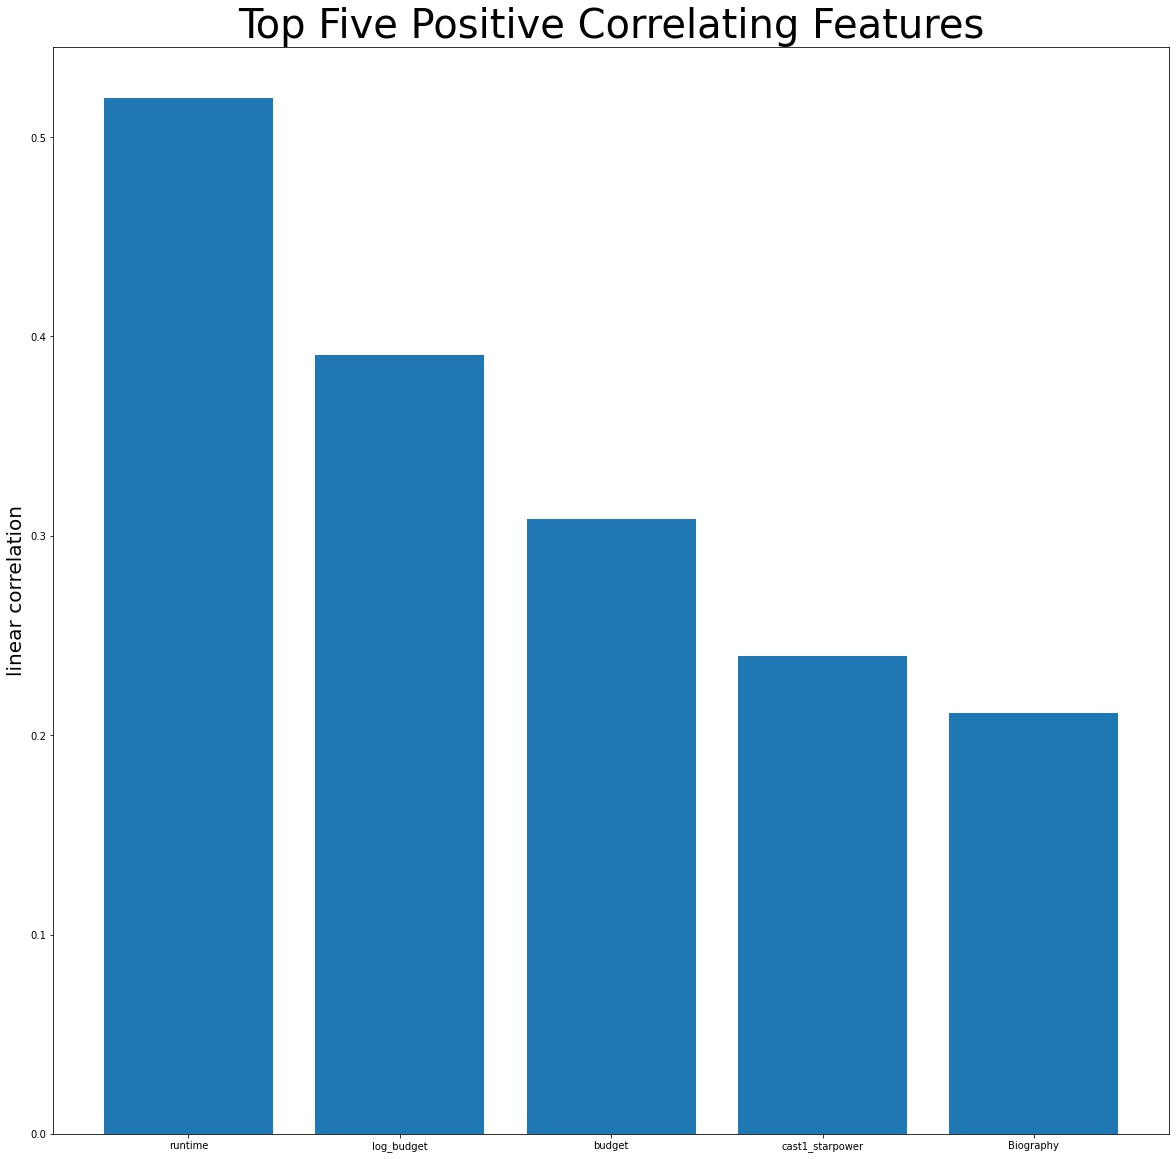

In [166]:
#top 5 positive correlations
plt.figure(figsize=(20,20))
plt.ylabel("linear correlation",fontsize=20)
plt.title("Top Five Positive Correlating Features",fontsize=40)
plt.rc('xtick', labelsize=10) 
plt.bar(movie_for_modelling_corr_df.iloc[1:6,0],movie_for_modelling_corr_df.iloc[1:6,1])
plt.savefig("top5_positive.png")
plt.show();


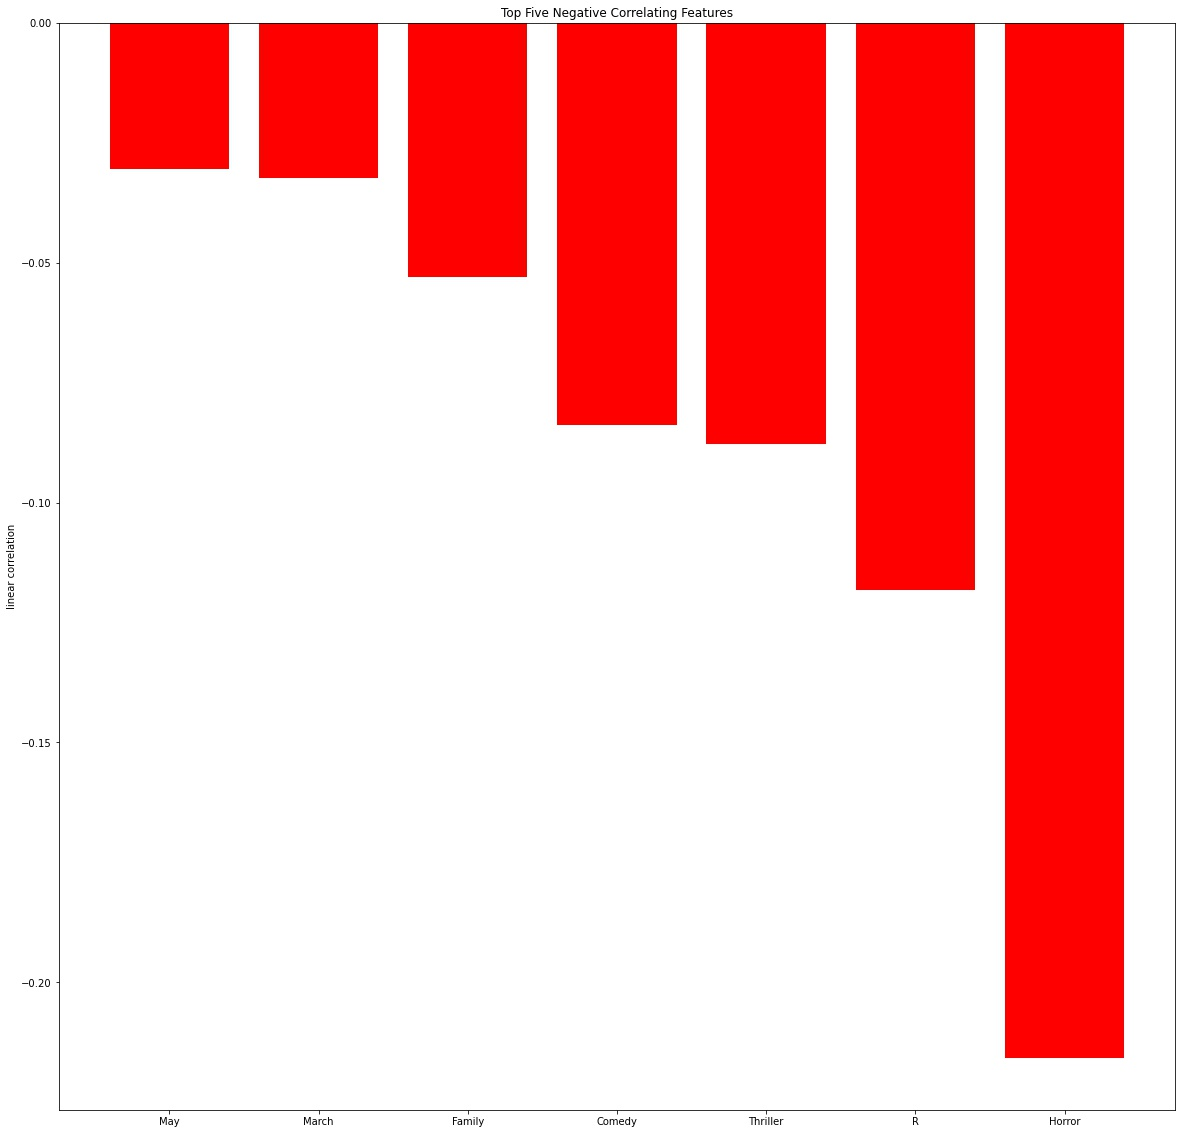

In [167]:
#top 5 negative correlations
plt.figure(figsize=(20,20))
plt.ylabel("linear correlation")
#plt.rc('xtick') 
plt.title("Top Five Negative Correlating Features")
plt.bar(movie_for_modelling_corr_df.iloc[-7:,0],movie_for_modelling_corr_df.iloc[-7:,1],color="red")
plt.savefig("top5_negative.png")
plt.show();

### Residule Plot

In [168]:
Y_test.shape

(213,)

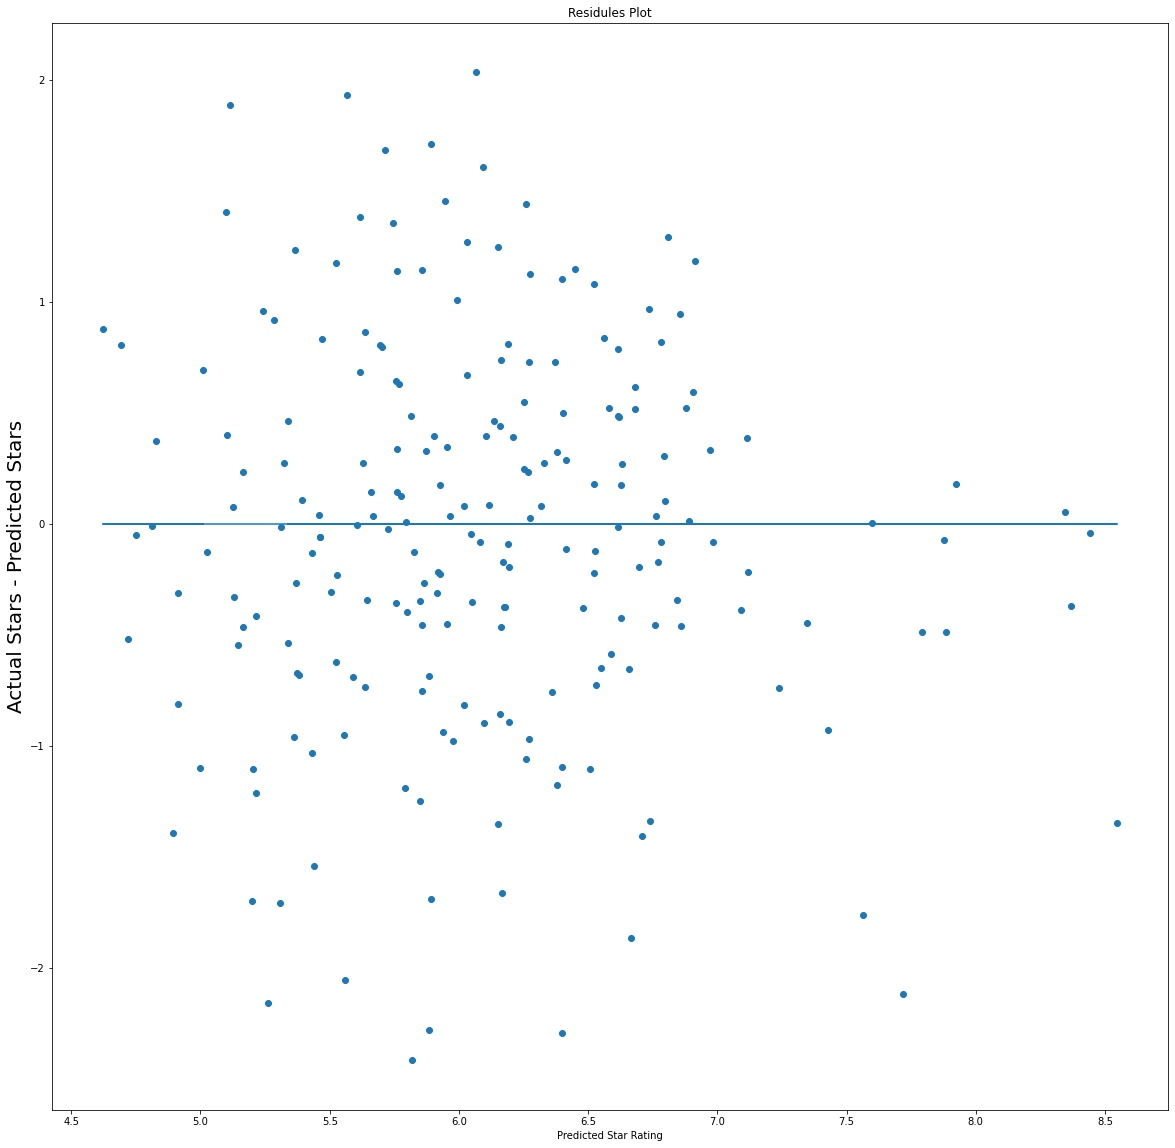

In [169]:
Y_hat = model3.predict(X_test)
residules = Y_test - Y_hat
plt.figure(figsize=(20,20))
plt.scatter(Y_hat,residules)
plt.rc('xtick', labelsize=1) 
plt.plot(Y_hat,np.zeros(Y_hat.shape[0]))
plt.title("Residules Plot")
plt.xlabel("Predicted Star Rating",fontsize=10)
plt.ylabel("Actual Stars - Predicted Stars",fontsize=20)
plt.savefig("residules.png")
plt.show();

The mean of the residules should be close to zero

In [170]:
np.mean(residules)

-0.05930497128174736

/Users/magreen/Anaconda3-2020_07/envs/tensorflow_in_practice/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


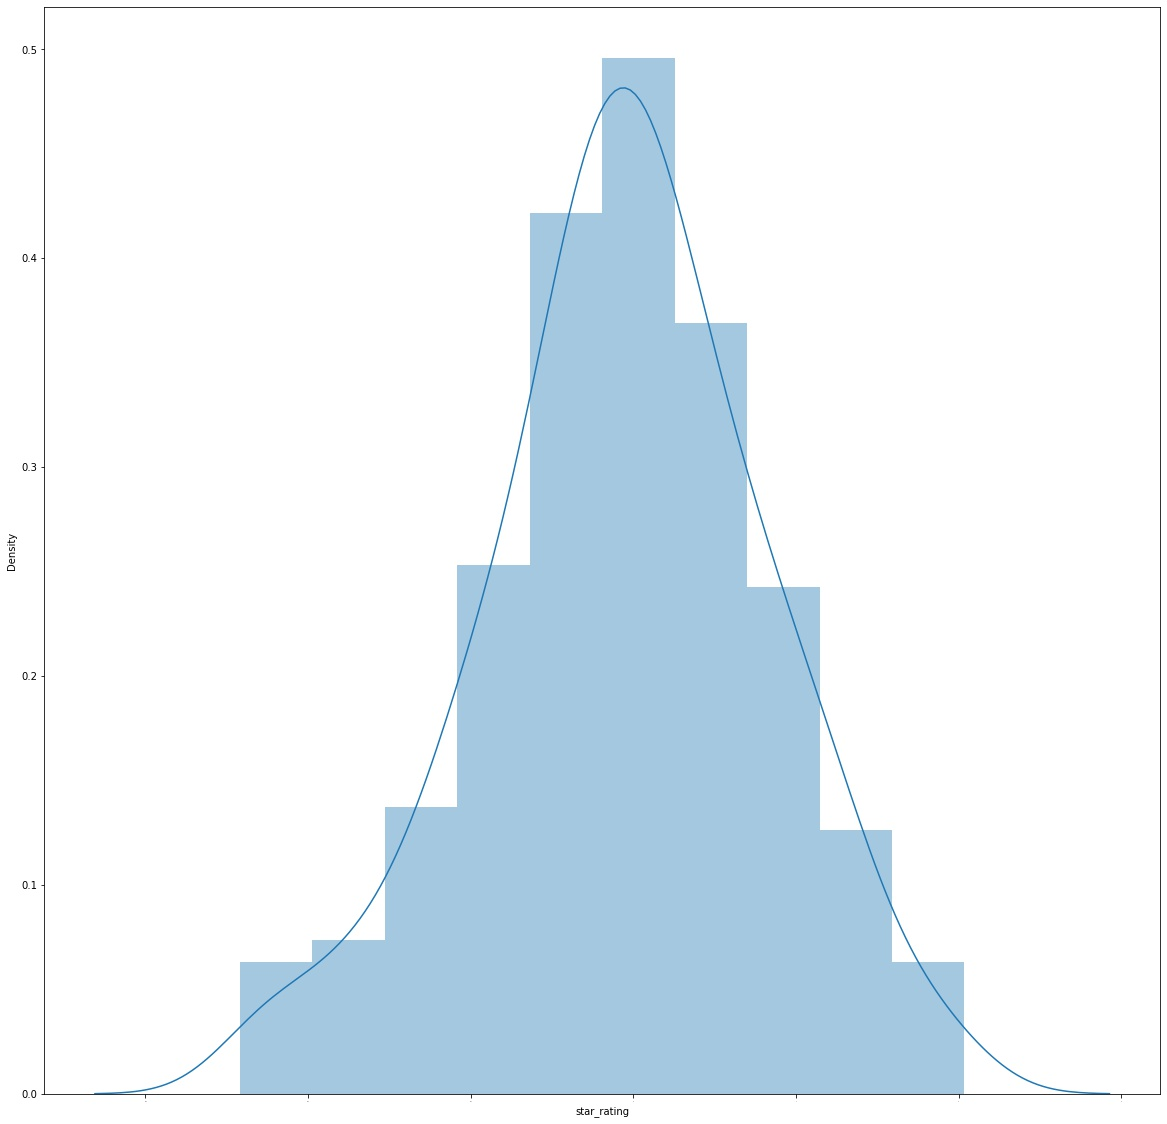

In [171]:
plt.figure(figsize=(20,20))
sns.distplot(residules,bins=10)
plt.savefig("residule_distplot.png");

In a good model the distribution of its errors should take on a normal distribution.

Q-Q Plot

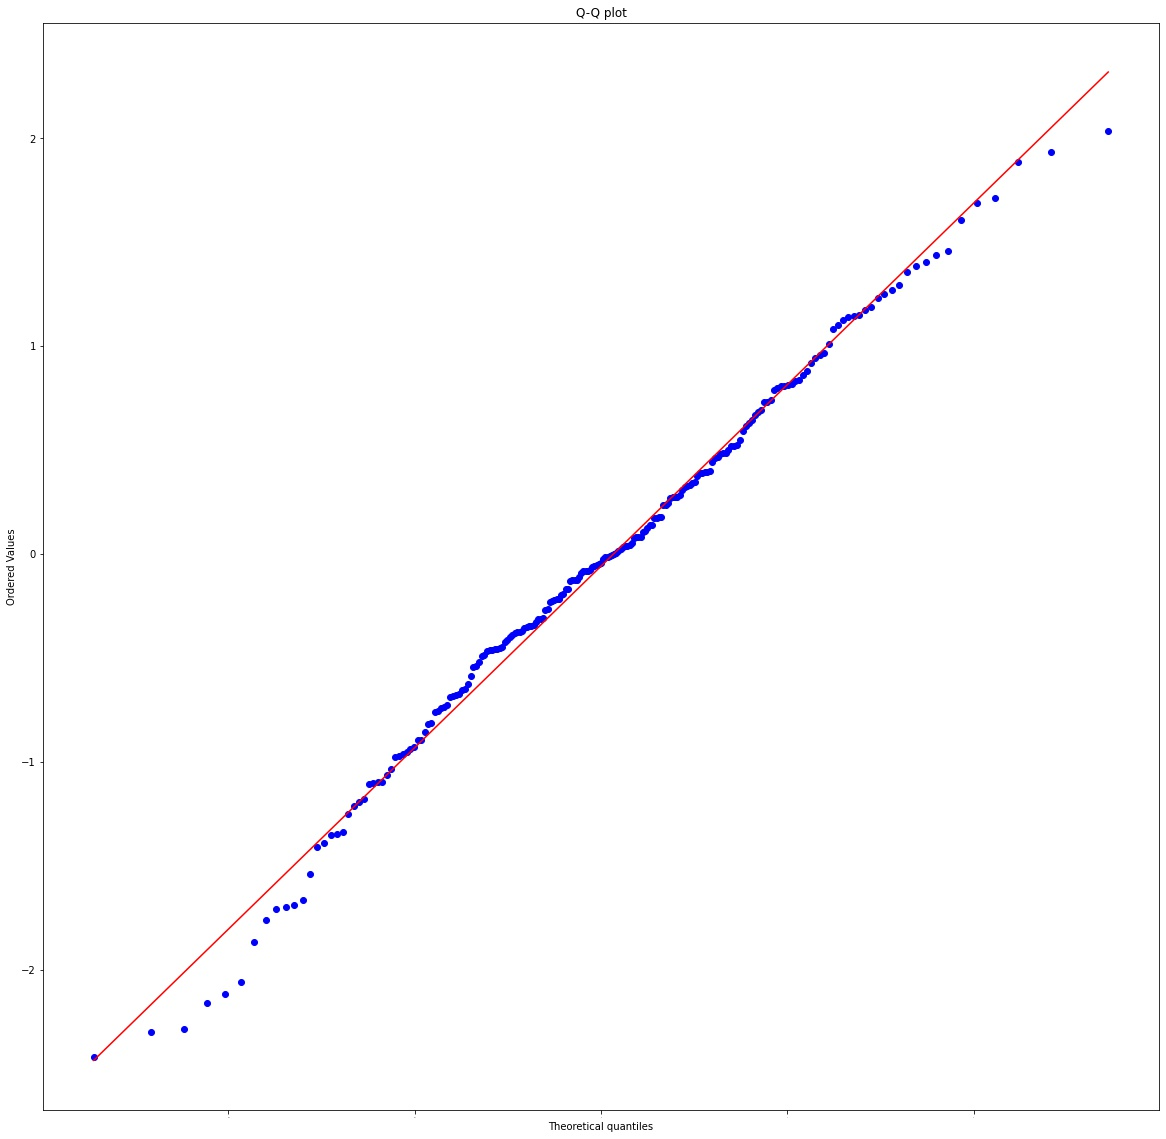

In [172]:
plt.figure(figsize=(20,20))
stats.probplot(residules, dist="norm", plot=plt)
plt.title("Q-Q plot")
plt.savefig("q_q_plot.png")
plt.show();


In a good model, the blue dots should sit very closely on the middle part of the red.